In [1]:
from IPython.display import Image, display

## Hypothesis

I'm going to give you a set of data. This set of data, the y-values will be generated in one of two ways (or a combination).

 - An $\alpha$ process ($\alpha$ process)
 - A wavelength process (w process)

Here is a single system, plotted as though it was generated in either $\alpha$ or w processes (and transitions smoothly between them to highlight the fact that that y-values are the same. It is merely the x-axis that gets changed:

![alt text](../img/02-animation.gif "Switch")

**Given a dataset, can you devise a test that quantifies the relative likelihood of either process $\alpha$ or w generating it?**

One extra piece of information that is important: if $\alpha$ is generating a signal, it must be a straight line in the $\alpha$ plot. If it is a w-process, it can be more flexible. 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings

warnings.filterwarnings('ignore')

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import GridSpec
from itertools import combinations, islice, takewhile
import seaborn as sns
import mpld3
import numpy as np
import pandas as pd
import scipy.sparse

import os, sys
import warnings
from astropy import units as u
from astropy.coordinates import SkyCoord
import statsmodels.api as sm
sns.set_context('poster', font_scale=1.3)

from ipywidgets import interact, FloatSlider, SelectMultiple, interactive

In [ ]:
# 'constants'
from scipy.constants import c # speed of light in m/s

DIP_RA = 17.3
DIP_RA_ERR = 1.0
DIP_DEC = -61.0
DIP_DEC_ERR = 10.0
DIP_AMPLITUDE = 0.97e-5
DIP_AMPLITUDE_ERR = 0.21e-5 # average of asymmetric errors
DIP_MONOPOLE = -0.178e-5
DIP_MONOPOLE_ERR  = 0.084e-5

dipole = SkyCoord(DIP_RA, DIP_DEC, unit=(u.hourangle, u.deg))

# Data
vltqs = pd.read_csv('../data/vlt-transitions-new.tsv', sep='\t')
vltqs['trans'] = vltqs['transition'] + vltqs.four.astype(str)

keckqs = pd.read_csv("../data/keck-transitions-new.tsv", sep='\t')
keckqs['trans'] = keckqs.transition + keckqs.four.astype(str)

qvals = pd.read_csv("../data/qvalues.txt", sep=' ', index_col=0)

codes = pd.concat([keckqs.set_index('code')[['trans', 'wavelength']],
                   vltqs.set_index('code')[['trans', 'wavelength']]])


def extra_eda(row):
    """King 2012 has extra 'random' systematic error added in quadrature."""
    if row.sigflag == 3:
        extra = 9.05
    elif row.sigflag == 2:
        extra = 17.43
    else:
        extra = 0.0
    return np.sqrt(row.eda ** 2.0 + extra ** 2.0)

def assign_dipole(row):
    """Assign best-fit dipole from King 2012 to column in dataset."""
    return dipole_alpha(row['#J2000'])


full_parse = pd.read_csv("../data/full-parse.tsv", sep='\t')
full_parse['extraeda'] = full_parse.apply(extra_eda, axis=1)

full_parse['dipole_fit'] = full_parse.apply(assign_dipole, axis=1)

In [206]:
def assign_dipole_angle(row):
    """King 2012 angle from pole to position on sky via J2000."""
    return j2000_to_theta(row['#J2000'])

full_parse['dipole_angle'] = full_parse.apply(assign_dipole_angle, axis=1)

In [208]:
vlt = full_parse[full_parse.source.eq('VLT')].copy()
keck = full_parse[full_parse.source.eq('Keck')].copy()

In [204]:
# [len(x) for x in np.array_split(vlt.sort_values('zabs'), 13)]

In [175]:
# From: http://nbviewer.jupyter.org/github/mgeier/python-audio/blob/master/plotting/matplotlib.ipynb
# def myplot(data, ax=None):
#     """A special plotting function for my special needs."""
#     if ax is None:
#         ax = plt.gca()
#     x = np.arange(len(data)) * 1000  # my special x-axis needs
#     lines = ax.plot(x, data)
#     ax.set_xlabel("my independent variable / millisomethings")
#     ax.set_ylabel("very interesting unitless values")
#     ax.grid(True)
#     return lines
def plot_a_v_z(dataframe, alphacol='da', errorcol='extraeda', color=0, label=''):
    fig = plt.gcf()
    ax = plt.gca()
    for index, df in enumerate(np.array_split(dataframe.sort_values('zabs'), 13)):
        x = np.average(df.zabs)
        y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
        e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        if index == 0:
            label=label
        else:
            label=''
        ax.scatter(x, y, c=sns.color_palette()[color], label=label)
        ax.errorbar(x, y, yerr=e, c=sns.color_palette()[color])
    ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
    ax.set_ylabel(r"$\Delta \alpha/\alpha$")
    ax.set_xlabel(r"Redshift [z]")
    ax.legend(loc='best')
    ax.set_xlim(0.3, 3.7)
    ax.set_ylim(-20, 20)
    fig.tight_layout()

In [195]:
np.array_split(keck.sort_values('zabs'), 13)[2]

#J2000   zem     zabs     da    eda sample source  sigflag  \
6    J000520+052410  1.90  0.85119   4.75  10.22      C   Keck        1   
93   J125048+395139  1.03  0.85452  -0.21  12.70      A   Keck        1   
38   J045647+040052  1.34  0.85929   5.78  12.05      A   Keck        1   
68   J111038+483115  2.97  0.86182 -20.24  16.36      C   Keck        1   
100  J142326+325220  1.91  0.90301  -9.99  17.83      A   Keck        1   
50   J082601-223027  0.91  0.91059  -3.91   6.09      A   Keck        1   
75   J120858+454035  1.16  0.92741  -2.18  13.90      C   Keck        1   
76   J120858+454035  1.16  0.92742  -2.80   7.77      A   Keck        1   
95   J125659+042734  1.02  0.93426  18.77  17.96      A   Keck        1   
40   J053007-250329  2.77  0.94398   7.58  23.37      C   Keck        1   
118  J220852-194359  2.56  0.94841 -36.64  18.57     B1   Keck        1   

     imrotator       transition  extraeda  dipole_fit  
6            0    e f n o p q r     10.22   -3.538861  
93           1      b c n p q r     12.70   -5.795437  
38           1    a c n o p r q     12.05   -7.044954  
68           1        a b c q r     16.36   -8.236147  
100          1    b c n o p q r     17.83   -3.526540  
50           1      b c n p q r      6.09   -1.495030  
75           1    b c n o p q r     13.90   -7.124609  
76           1  a b c n o p q r      7.77   -7.124609  
95           1      b c n p q r     17.96   -0.477096  
40           1            b c r     23.37   -2.440880  
118          1      b c n p q r     18.57    2.399563

In [197]:
def plot_a_v_zresid(dataframe, dataframe2, alphacol='da', alphacol2='dipole_fit', errorcol='extraeda', color=0, label=''):
    """Measured - model"""
    fig = plt.gcf()
    ax = plt.gca()
    nbins = 13
    for index in range(nbins):
        df = np.array_split(dataframe.sort_values('zabs'), nbins)[index]
        x = np.average(df.zabs)
        y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
        e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        
        df2 = np.array_split(dataframe2.sort_values('zabs'), nbins)[index]
        x2 = np.average(df2.zabs)
        y2 = np.average(df2[alphacol2], weights=(1.0 / (df2[errorcol] ** 2.0)))
        e2 = np.sqrt(1.0 / np.sum(1.0 / (df2[errorcol] ** 2.0)))
        if index == 0:
            label=label
        else:
            label=''
        ax.scatter(x, (y - y2), c=sns.color_palette()[color], label=label)
        ax.errorbar(x, (y - y2), yerr=e, c=sns.color_palette()[color])
    ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
    ax.set_ylabel(r"Residual $\Delta \alpha/\alpha$")
    ax.set_xlabel(r"Redshift [z]")
    ax.legend(loc='best')
    ax.set_xlim(0.3, 3.7)
    ax.set_ylim(-20, 20)
    fig.tight_layout()

In [220]:
def plot_a_v_theta(dataframe, alphacol='da', alphacol2='dipole_fit', errorcol='extraeda', color=0, label=''):
    """Measured - model"""
    fig = plt.gcf()
    ax = plt.gca()
    nbins = 13
    for index in range(nbins):
        df = np.array_split(dataframe.sort_values('dipole_angle'), nbins)[index]
        x = np.average(df.dipole_angle)
        y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
        e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        
        if index == 0:
            label=label
        else:
            label=''
        ax.scatter(x, (y), c=sns.color_palette()[color], label=label)
        ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color])
    ax.hlines(0, -2, 200, linestyles=':', lw=1.5, color='k')
    ax.vlines(90, -30, 30, linestyles=':', lw=1.5, color='k')
    ax.set_ylabel(r"Residual $\Delta \alpha/\alpha$")
    ax.set_xlabel(r"$\Theta$, angle from best-fitting dipole [degrees]")
    ax.legend(loc='best')
    ax.set_xlim(0.0, 180.0)
    ax.set_ylim(-25, 25)
    fig.tight_layout()

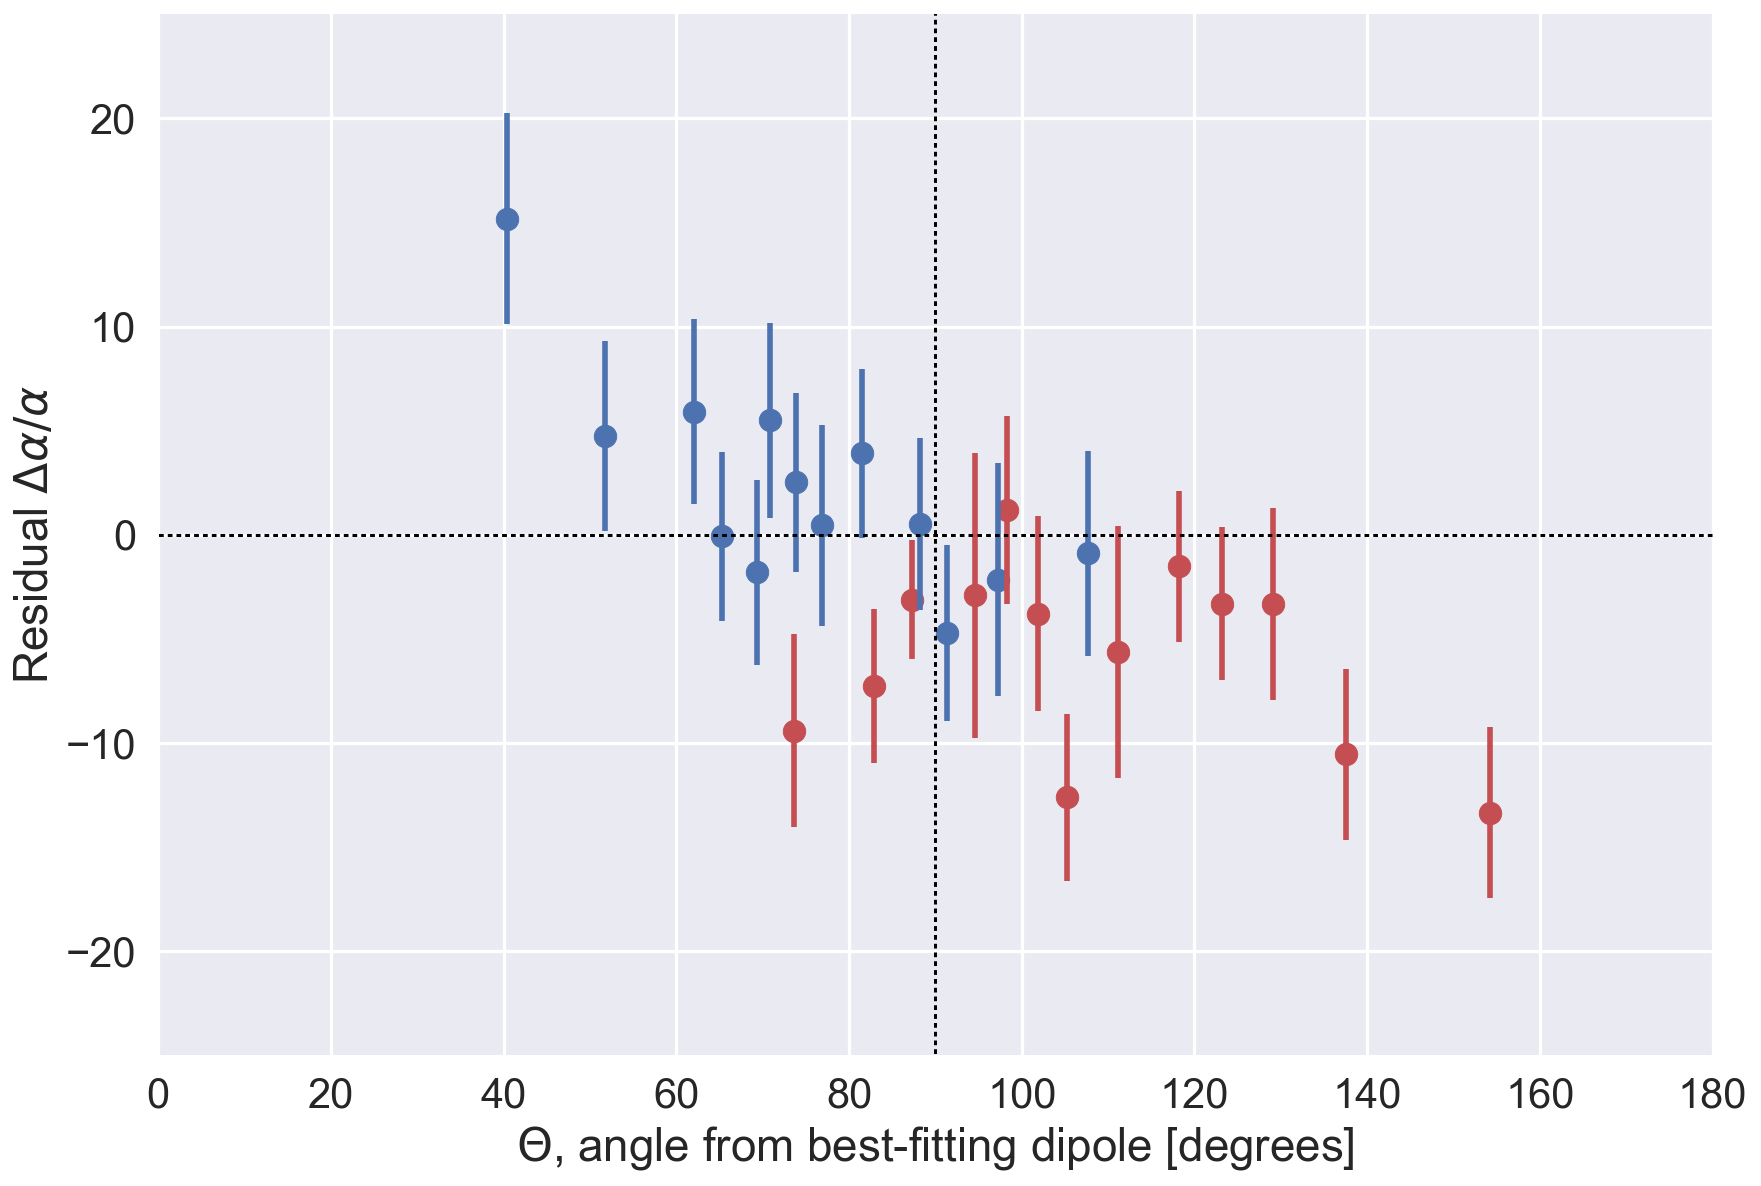

In [221]:
plot_a_v_theta(vlt, color=0)
plot_a_v_theta(keck, color=2)

In [223]:
for index, g in temp:
    tempdf = 
    for x in np.......:
        index

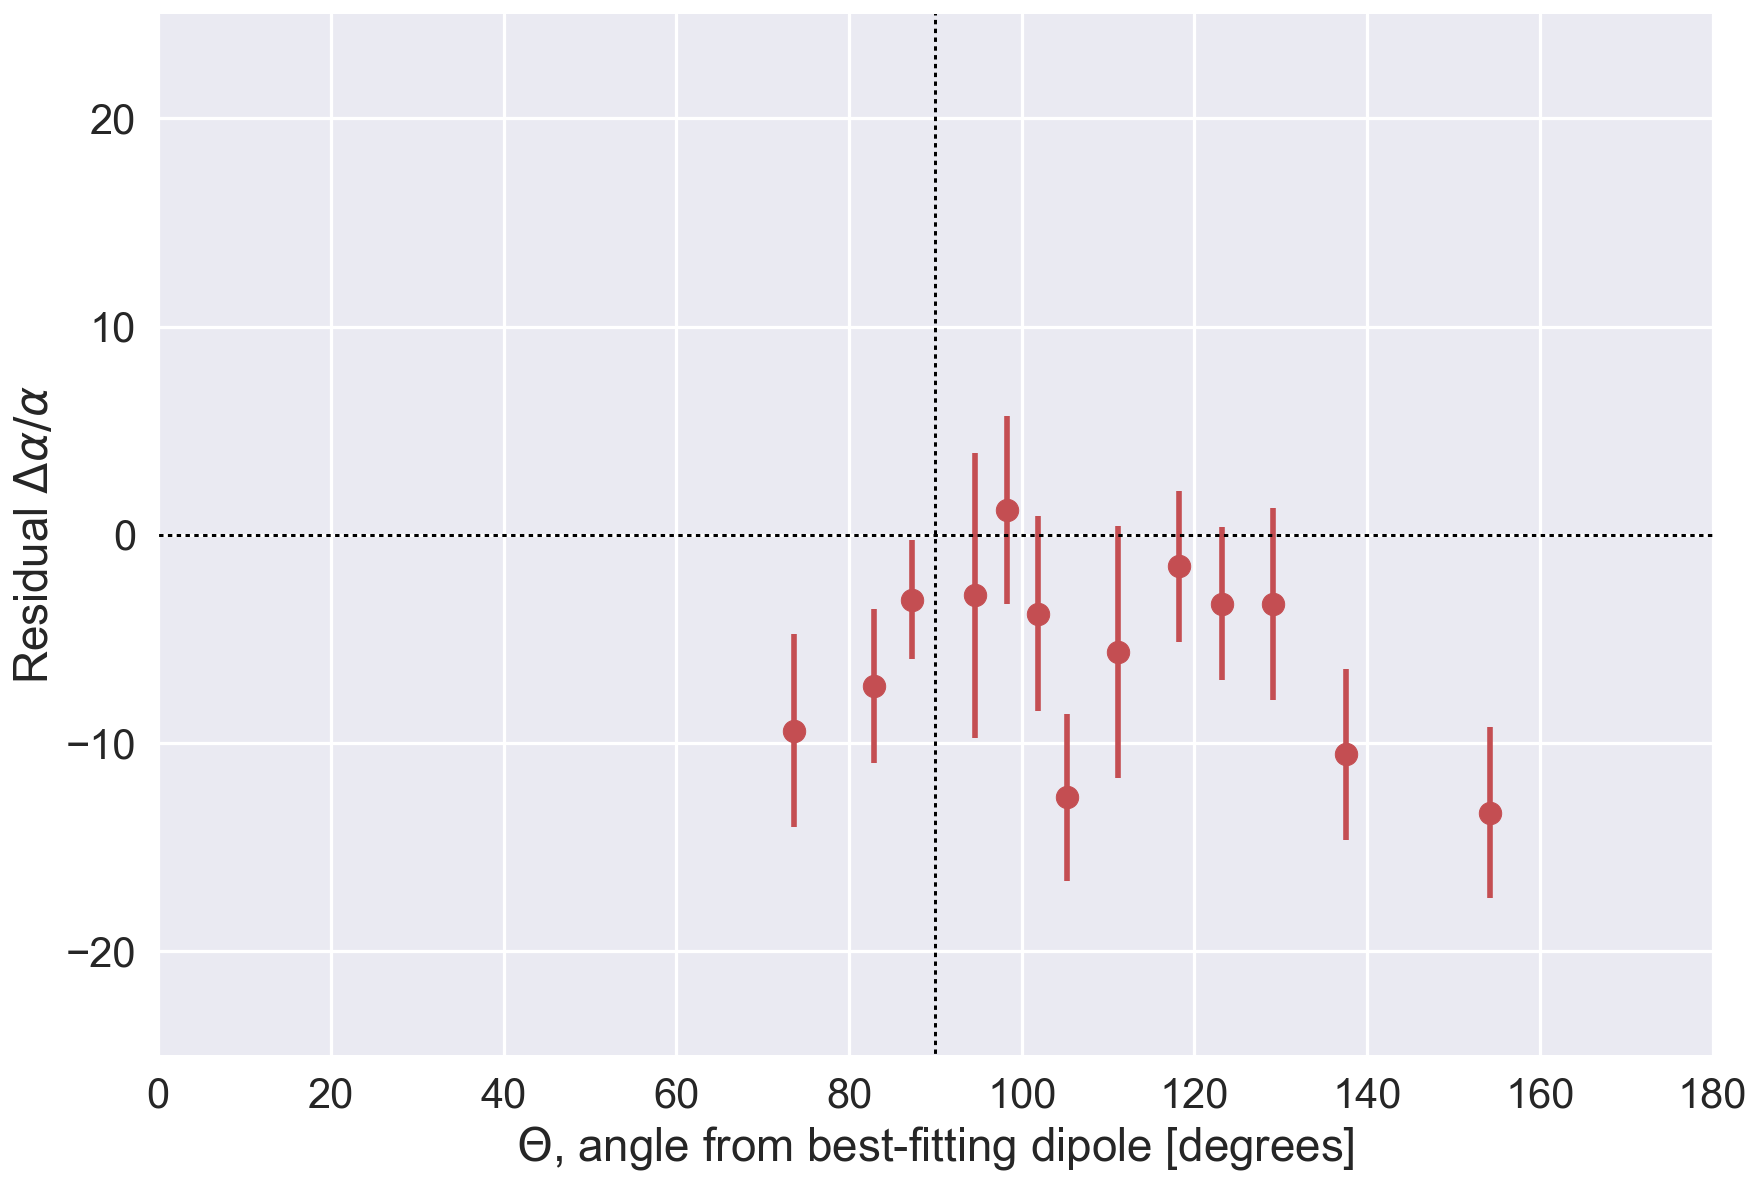

In [222]:
plot_a_v_theta(keck, color=2)

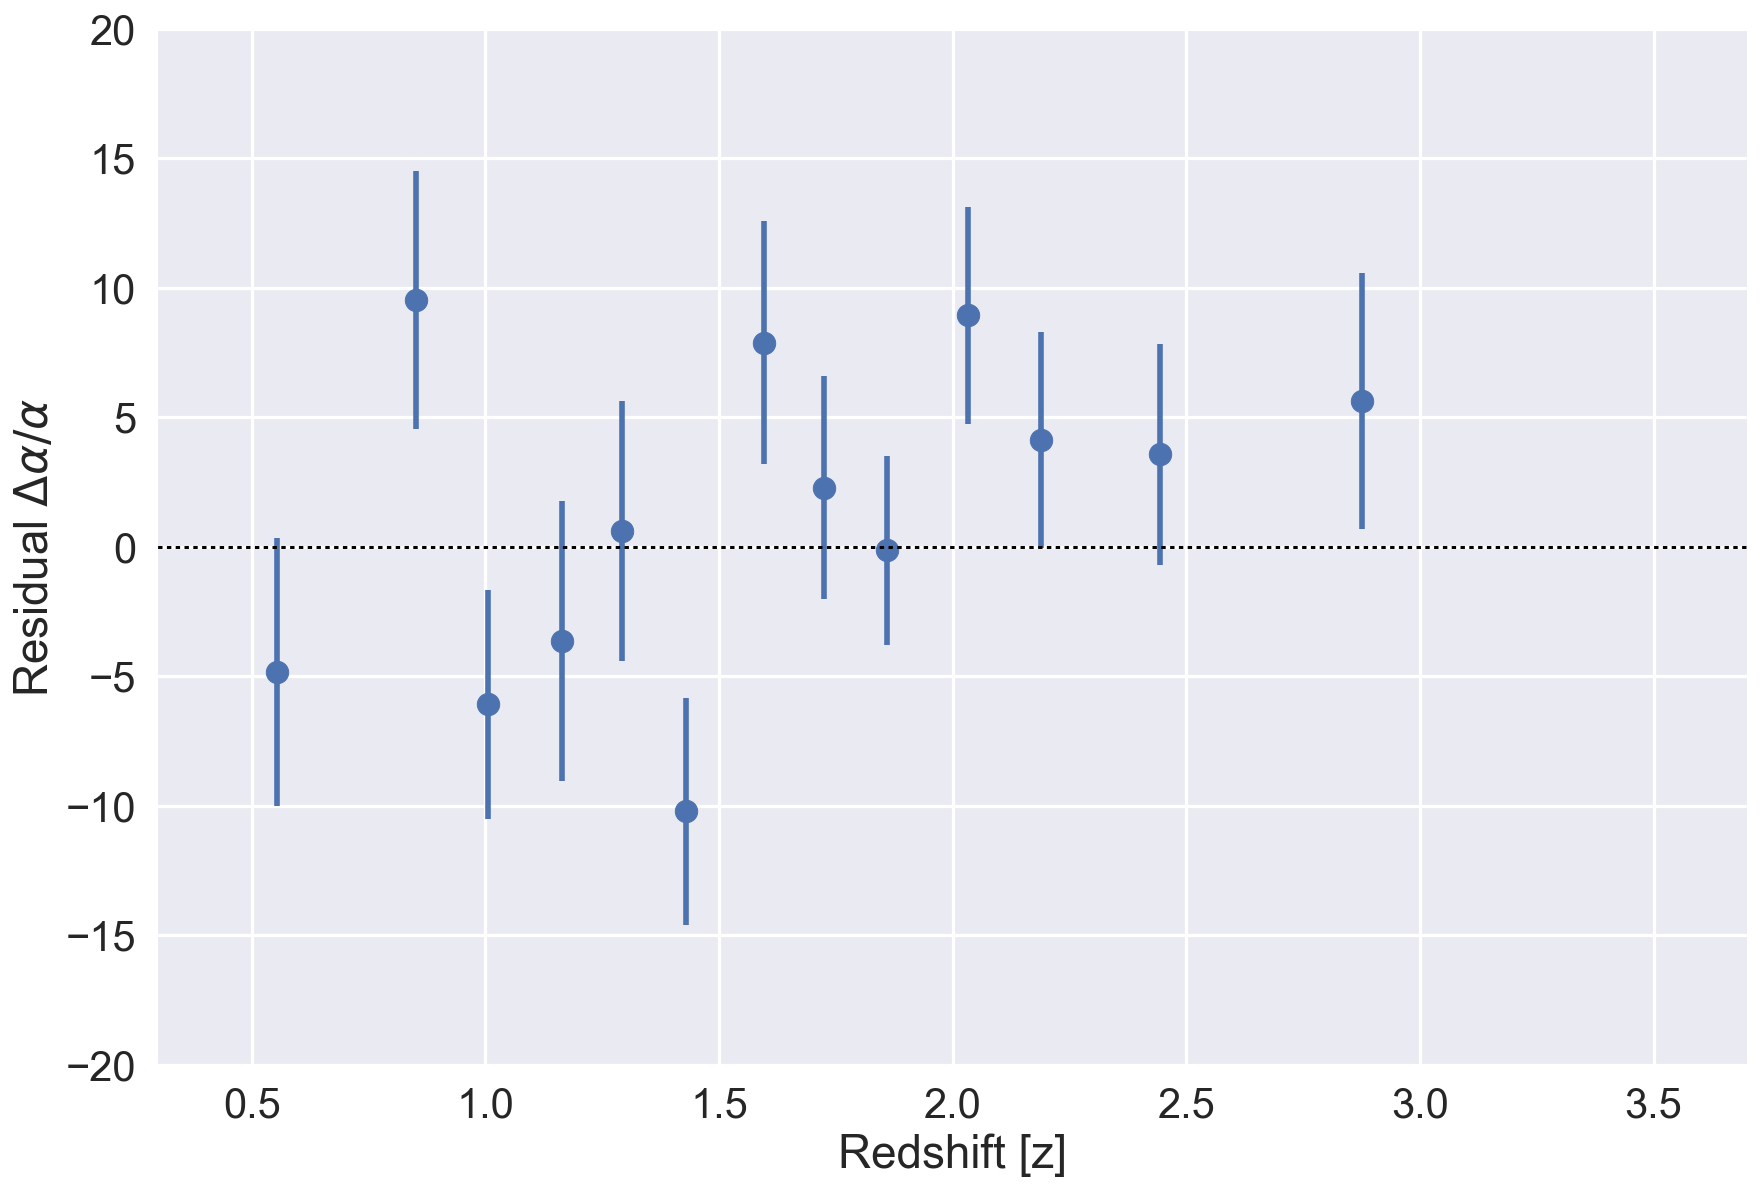

In [199]:
plot_a_v_zresid(vlt, vlt)

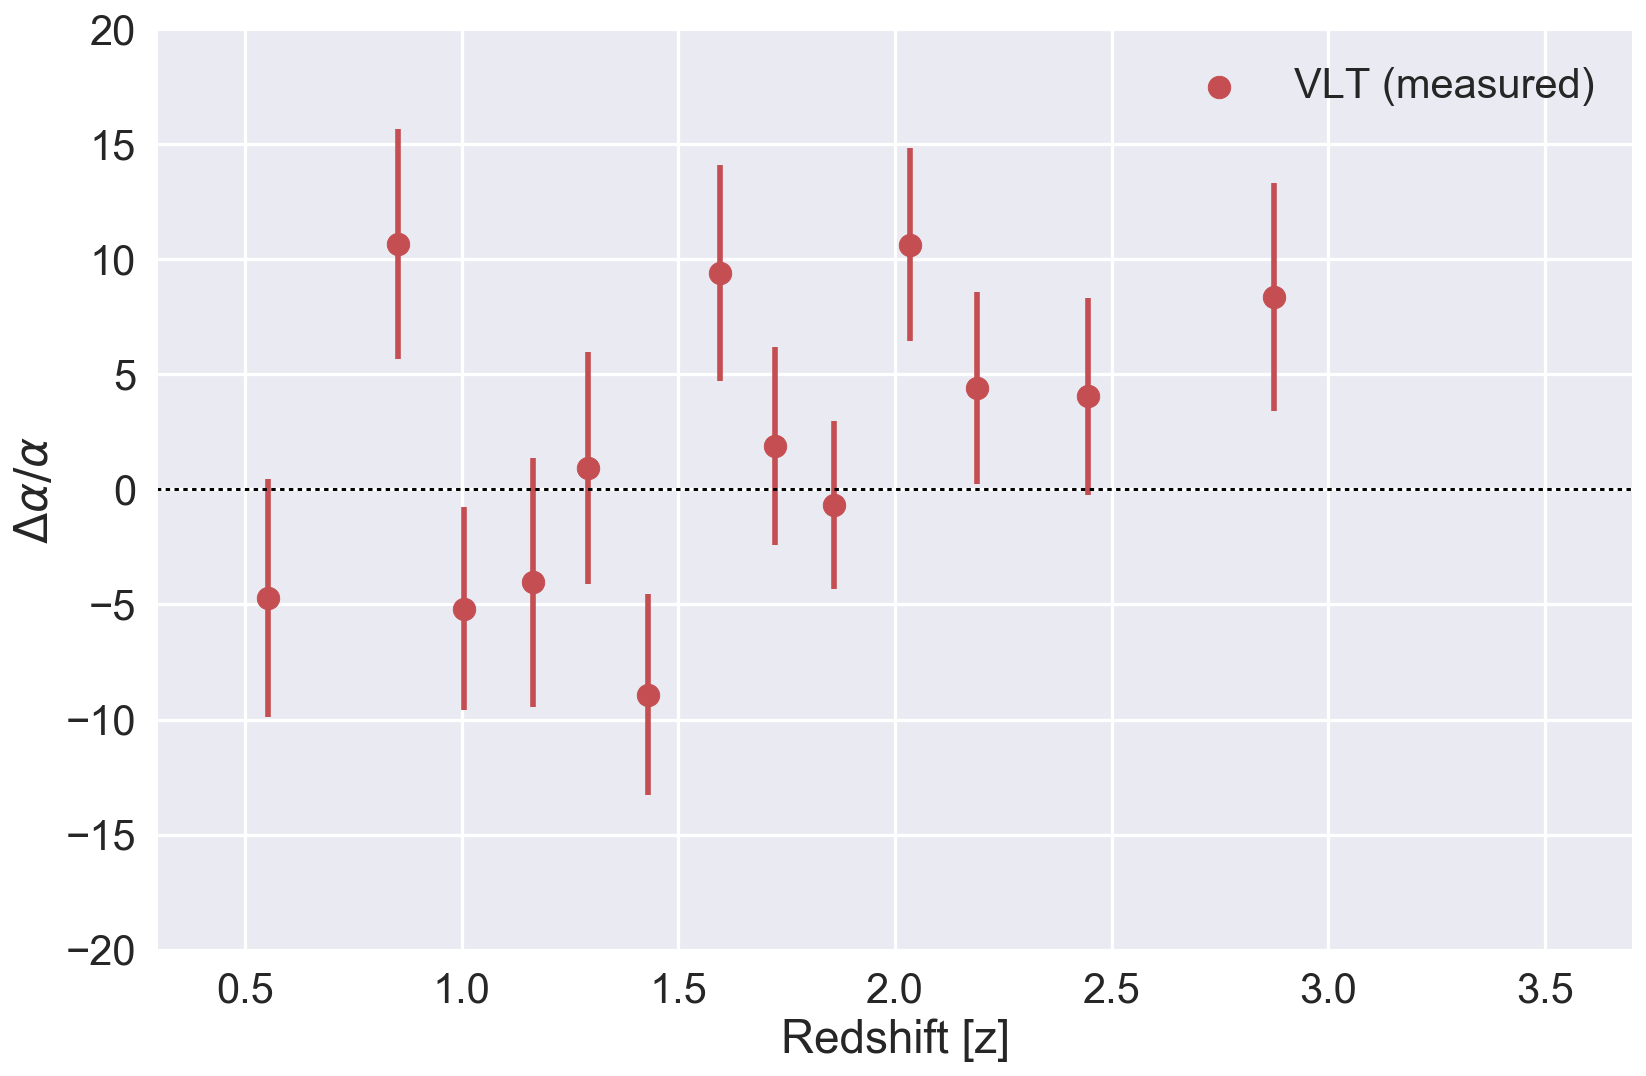

In [184]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(vlt, color=2, label='VLT (measured)')

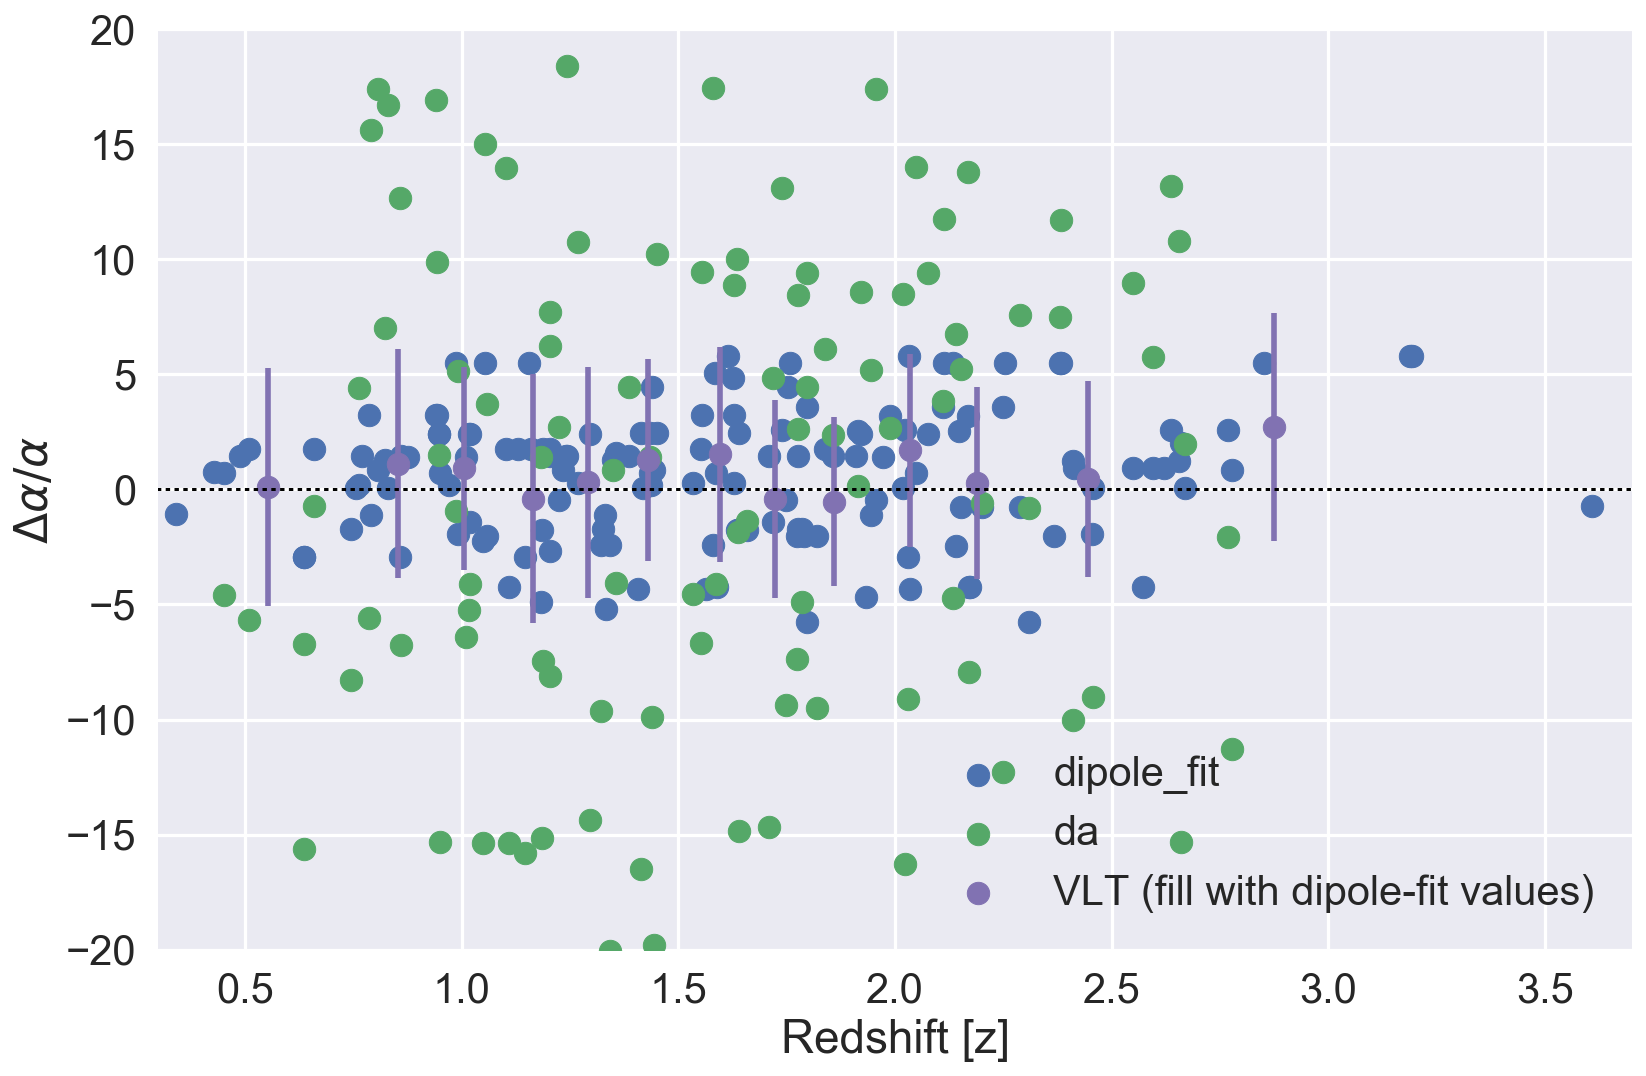

In [201]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(vlt.zabs, vlt.dipole_fit)
ax.scatter(vlt.zabs, vlt.da)
plot_a_v_z(vlt, alphacol='dipole_fit', color=3, label='VLT (fill with dipole-fit values)')

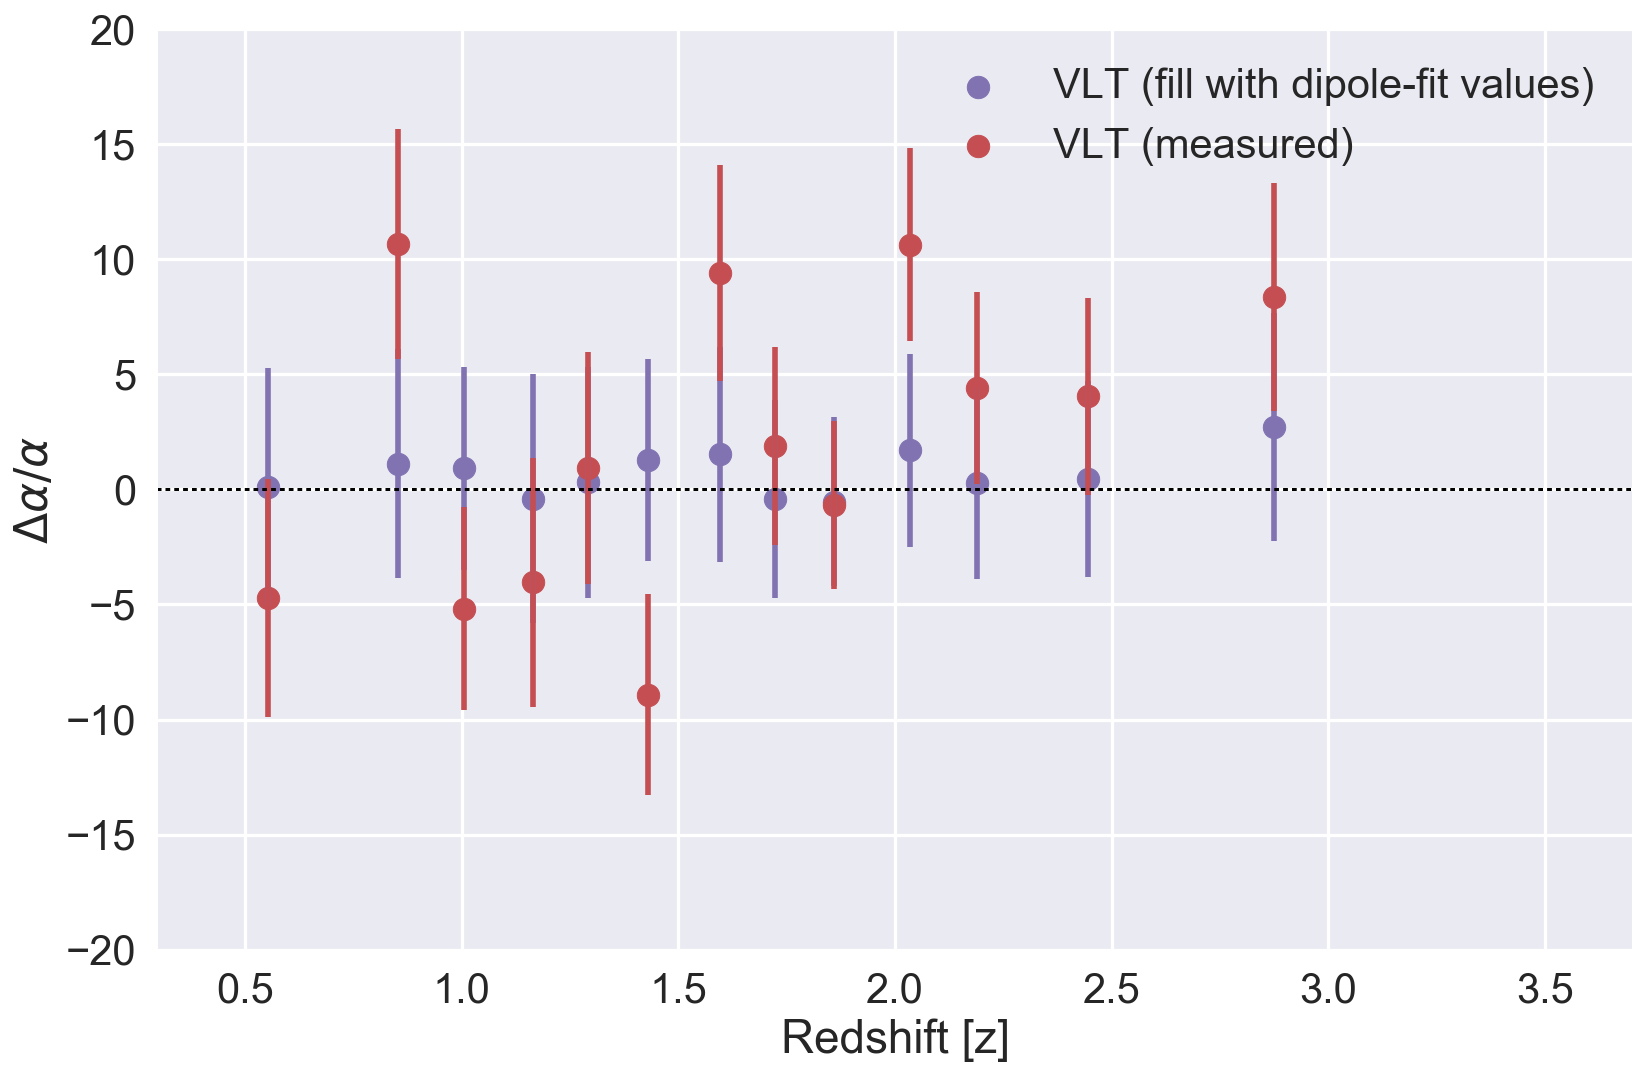

In [187]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(vlt, alphacol='dipole_fit', color=3, label='VLT (fill with dipole-fit values)')
plot_a_v_z(vlt, color=2, label='VLT (measured)')

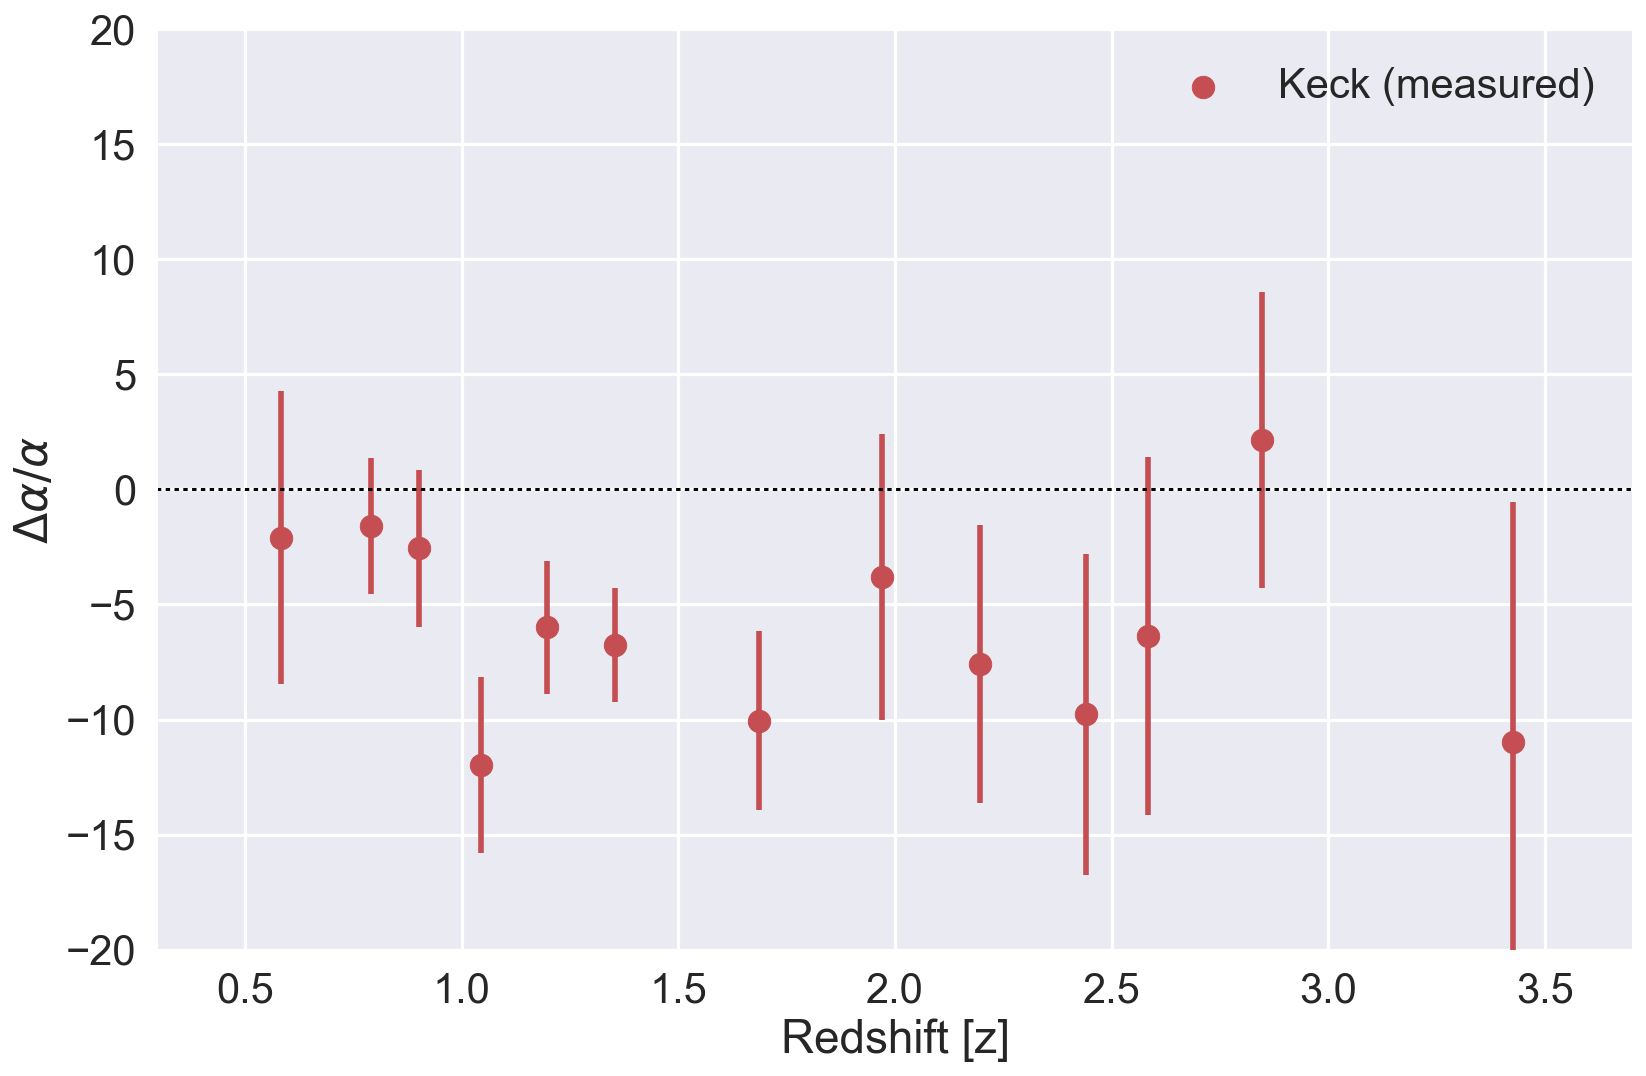

In [188]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, color=2, label='Keck (measured)')

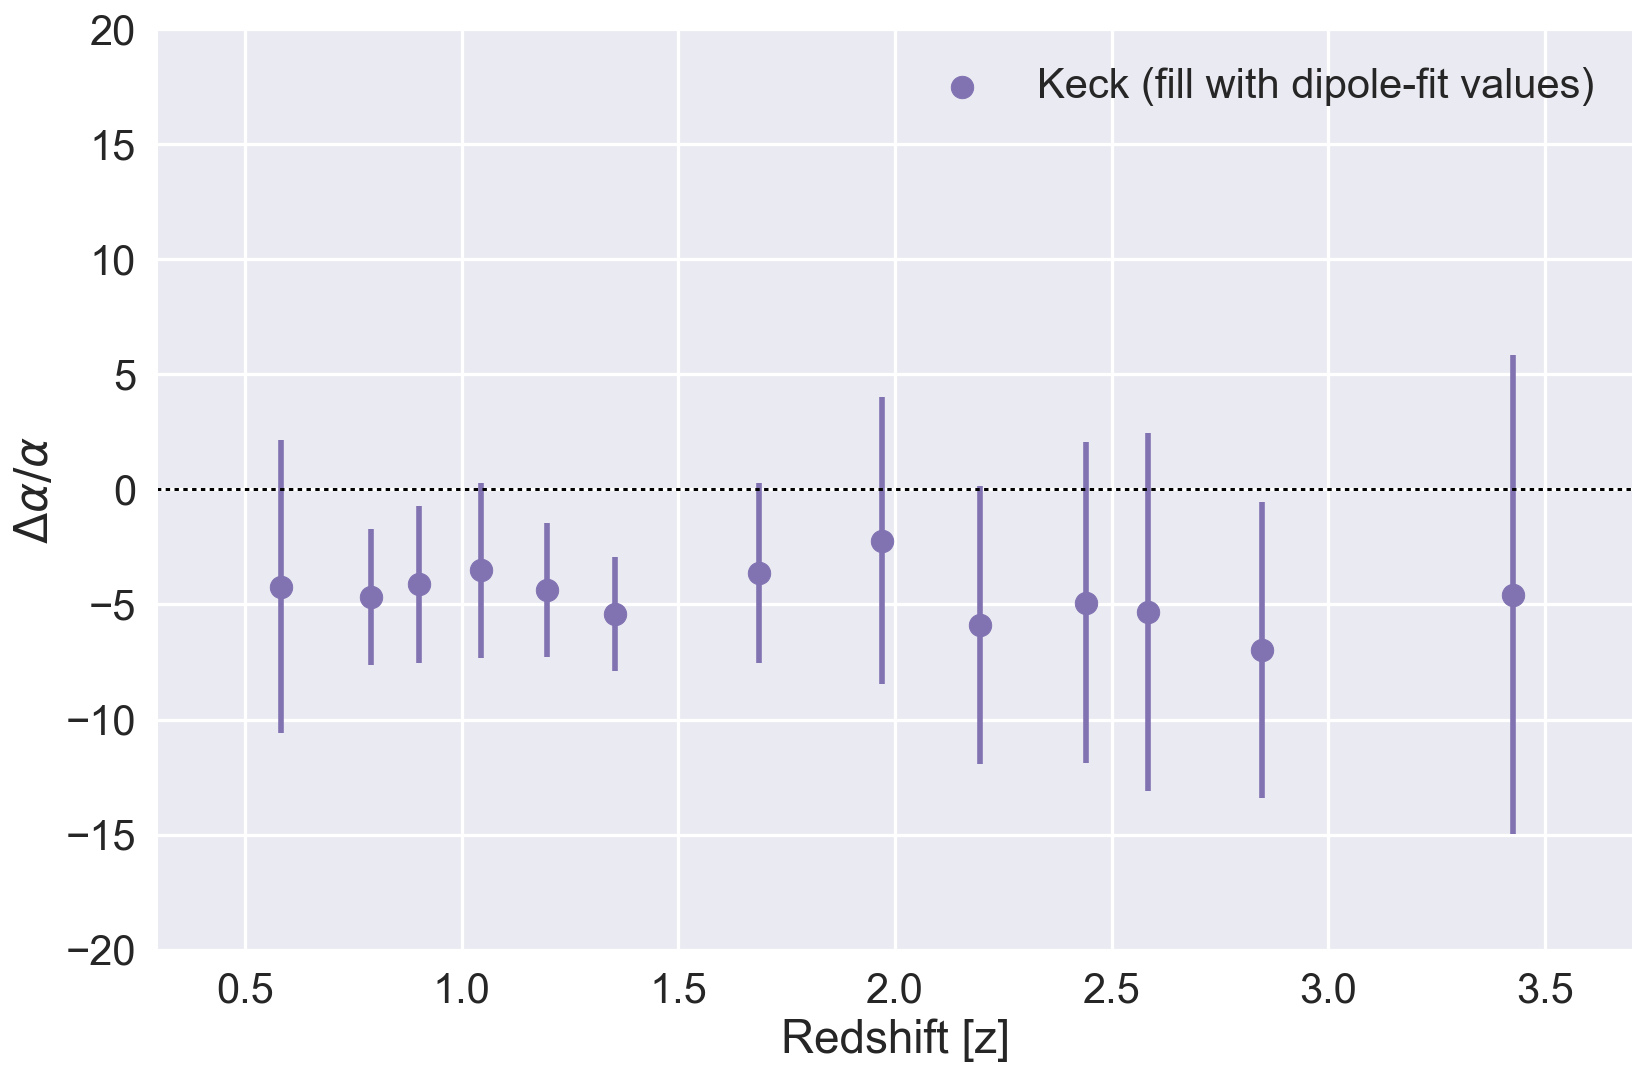

In [189]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, alphacol='dipole_fit', color=3, label='Keck (fill with dipole-fit values)')

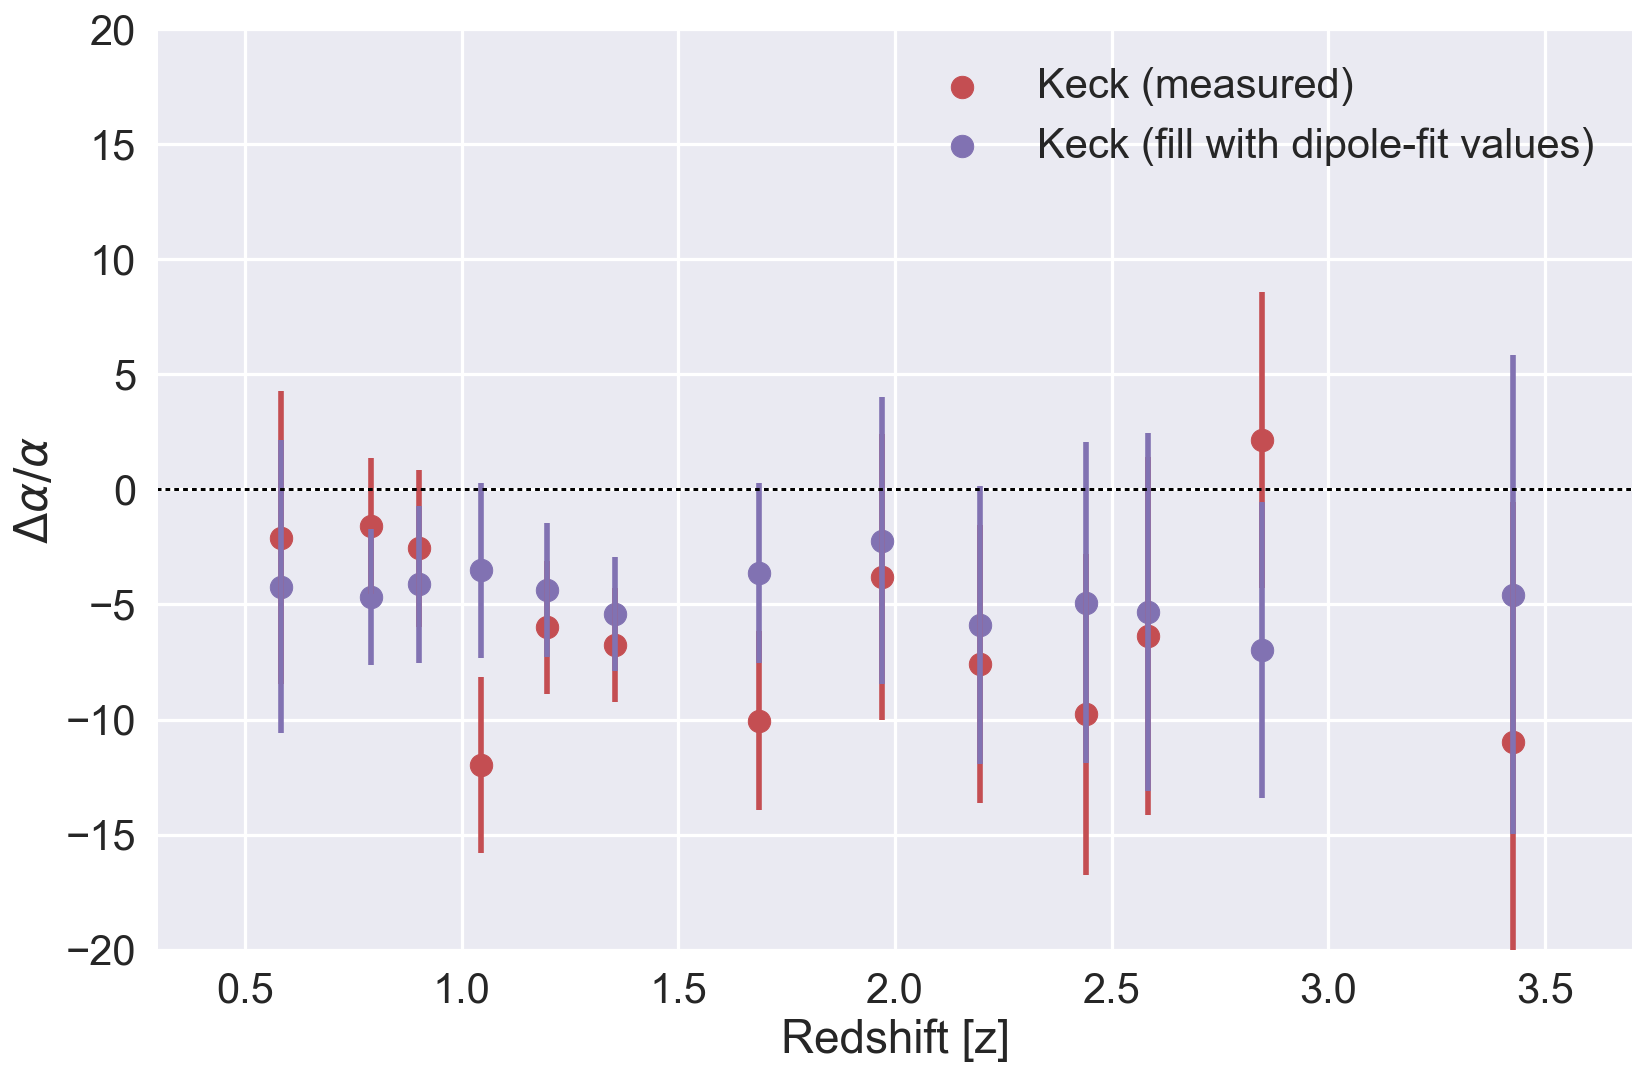

In [190]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, color=2, label='Keck (measured)')
plot_a_v_z(keck, alphacol='dipole_fit', color=3, label='Keck (fill with dipole-fit values)')

In [12]:
def observed_shifts(telescope='VLT'):
    waves = []
    shifts = []
    for index, row in full_parse[full_parse.source.eq(telescope)].iterrows():
        for tran in row['transition'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.zabs)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            shifts.append(shifted_velocity(row.da, qval, rest_wave))
    return np.array(waves), np.array(shifts)


def parse_j2000(name):
    """Takes the J2000 name stored in the results and returns it in a format astropy can understand."""
    return ' '.join([name[1:3], name[3:5], name[5:7], name[7:10], name[10:12], name[12:]])

def j2000_to_theta(name):
    """Returns the angle (degrees) between the position on the sky from 
    a given `name` and the position of the dipole model from 2012, King."""
    c = SkyCoord(parse_j2000(name), unit=(u.hourangle, u.deg))
    return float(c.separation(dipole).to_string(decimal=True))

def dipole_alpha(name):
    """Returns the value of Delta alpha/alpha as given by the best fit 2012 King model for 
    the given name (position).
    """
    theta = j2000_to_theta(name)
    return (DIP_AMPLITUDE * np.cos(np.deg2rad(theta)) + DIP_MONOPOLE) * 1e6

def plot_system(system, dataframe):
    plotdf = dataframe[dataframe.system == system]
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 10), nrows=2)
    sns.regplot('wavelength', 'vshift', data=plotdf, ax=ax1)
    sns.regplot('x', 'vshift', data=plotdf, ax=ax2)
    fig.tight_layout()

def generate_dataset(gen_dipole_alpha=True, 
                     wavelength_distortion=False,
                     seed=228,
                    ):
    df = pd.DataFrame(columns=['system',
                               '#J2000',
                               'source',
                               'wavelength',
                               'vshift', 
                               'sigma', 
                               'qval',
                               'rest_wave'
                              ])
    count = 0
    abs_count = 0
    for index, row in full_parse.iterrows():
        waves = []
        rest_waves = []
        vshifts = []
        qvals_list = []
        for tran in row['transition'].split():
            vshift = 0.0
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.zabs)
            qval = qvals.loc[codes.loc[tran].trans].qval
            if gen_dipole_alpha:
                vshift += shifted_velocity(dipole_alpha(row['#J2000']),
                                           qval,
                                           rest_wave)
            if wavelength_distortion:
                vshift += distorted_velocity(row, measured_wave)
            waves.append(measured_wave)
            rest_waves.append(rest_wave)
            vshifts.append(vshift)
            qvals_list.append(qval)
        vshifts = np.array(vshifts)
        errors = sigmas(vshifts)
        vshifts += errors * np.random.randn(len(vshifts))
        vshifts = vshifts - vshifts[0]
        for single in range(len(vshifts)):
            abs_count += 1
            df.loc[abs_count] = [int(index), #system
                                 row['#J2000'], #j2000
                                 row.source,
                                 waves[single], #wavelength 
                                 vshifts[single],
                                 errors[single],
                                 qvals_list[single], # qvalues
                                 rest_waves[single],
                                ]
    df['system'] = df.system.astype(int)
    # For numerical stability during fitting, dividing the x-values by 1.3e13
    df['x'] = -2.0 * c * df['qval'] * df['rest_wave'] / 1.0e13
    return df

def shifted_velocity(del_alpha, q, lamb):
    # vj =v0 + ∆α xj, xj =−2cqjλ0j,
    x = -2 * c * q * lamb
    return del_alpha * x * 1e-14

def sigmas(vshifts):
    return np.random.rand(len(vshifts)) * 30.0 + 50.0

def VLT_distortion(measured_wave, 
                   cutoff=10000., 
                   slope1=0.06, 
                   intercept1 = -100.0,
                   slope2 =0.160,
                   intercept2=-1500.0,
                  ):
    """Telescope dependent distortion function for the VLT sample."""
    if measured_wave < cutoff:
        return measured_wave * slope1 + intercept1
    else:
        return measured_wave * slope2 + intercept2

def Keck_distortion(measured_wave, cutoff=10000.):
    """Telescope dependent distortion function for the Keck sample."""
    slope1 = .0600
    intercept1 = -100
    slope2 = .160
    intercept2 = -1500
    if measured_wave < cutoff:
        return measured_wave * slope1 + intercept1
    else:
        return measured_wave * slope2 + intercept2
    
def distorted_velocity(row, measured_wave):
    """Telescope dependent distortion function for the VLT sample."""
    if row.source == "VLT":
        return VLT_distortion(measured_wave)
    elif row.source == "Keck":
        return Keck_distortion(measured_wave)

In [13]:
df_a = generate_dataset(gen_dipole_alpha=True, wavelength_distortion=False)
df_w = generate_dataset(gen_dipole_alpha=False, wavelength_distortion=True)

In [71]:
full_parse.head()

#J2000   zem     zabs     da    eda sample source  sigflag  \
0  J000149-015940  2.31  2.09510   0.34   7.27     B1   Keck        2   
1  J000149-015940  2.31  2.15390  36.05  39.54     B1   Keck        1   
2  J000322-260316  4.11  1.43420 -12.53  11.67      C   Keck        1   
3  J000322-260316  4.11  3.38970 -78.43  35.48      C   Keck        1   
4  J000520+052410  1.90  0.59137 -31.05  24.33      C   Keck        1   

   imrotator               transition  
0          0  d g h i j k l s t u v w  
1          0                  d f g l  
2          1                  b c p r  
3          1                  d g l m  
4          0              b c n p q r

In [14]:
def fit_hypothesis(system=0, dataframe1=df_a, hypothesis='x'):
    """Return the chisq and the fit model object for a given dataframe and hypothesis."""
    plotdf1 = dataframe1[dataframe1.system == system]
    assert(hypothesis in ['x', 'w'])
    if hypothesis == 'x':
        X = sm.add_constant(plotdf1.x)
    elif hypothesis == 'w':
        X = sm.add_constant(plotdf1.wavelength)
    results = sm.WLS(plotdf1.vshift, X, weights=1.0/plotdf1.sigma).fit()
    chisq = np.sum((plotdf1.vshift - results.fittedvalues)**2.0 / (plotdf1.sigma) ** 2.0)
    return chisq, results

def plot_hypotheses(system, dataframe1, dataframe2):
    plotdf1 = dataframe1[dataframe1.system == system]
    plotdf2 = dataframe2[dataframe2.system == system]
    fig, ((ax2, ax4), (ax3, ax1)) = plt.subplots(figsize=(14, 10), nrows=2, ncols=2, )
    
    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe1, hypothesis='w')
    ax1.errorbar(plotdf1.wavelength, plotdf1.vshift, yerr=plotdf1.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[2])
    ax1.scatter(plotdf1.wavelength, plotdf1.vshift, color=sns.color_palette()[2], label='')
    ax1.plot(plotdf1.wavelength, mod_one.fittedvalues, color='k')

    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe1, hypothesis='x')
    ax3.errorbar(plotdf1.x, plotdf1.vshift, yerr=plotdf1.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[0])
    ax3.scatter(plotdf1.x, plotdf1.vshift, color=sns.color_palette()[0], label='')
    ax3.plot(plotdf1.x, mod_one.fittedvalues, color='k')

    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe2, hypothesis='w')
    ax2.errorbar(plotdf2.wavelength, plotdf2.vshift, yerr=plotdf2.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[0])
    ax2.scatter(plotdf2.wavelength, plotdf2.vshift, color=sns.color_palette()[0], label='')
    ax2.plot(plotdf2.wavelength, mod_one.fittedvalues, color='k')

    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe2, hypothesis='x')
    ax4.errorbar(plotdf2.x, plotdf2.vshift, yerr=plotdf2.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[2])
    ax4.scatter(plotdf2.x, plotdf2.vshift, color=sns.color_palette()[2], label='')
    ax4.plot(plotdf2.x, mod_one.fittedvalues, color='k')

    autoAxis = ax2.axis()
    rec = Rectangle((autoAxis[0],
                     autoAxis[2]),
                    (autoAxis[1]-autoAxis[0]),
                    (autoAxis[3]-autoAxis[2]),
                    fill=False,lw=2)
    rec = ax2.add_patch(rec)
    rec.set_clip_on(False)
    
    autoAxis = ax3.axis()
    rec = Rectangle((autoAxis[0],
                     autoAxis[2]),
                    (autoAxis[1]-autoAxis[0]),
                    (autoAxis[3]-autoAxis[2]),
                    fill=False,lw=2)
    rec = ax3.add_patch(rec)
    rec.set_clip_on(False)
    
    ax3.set_title(r"$\alpha$ process $\alpha$ fit")
    ax2.set_title(r"W process W fit")
    ax1.set_title(r"$\alpha$ process W fit")
    ax4.set_title(r"W process $\alpha$ fit")
    ax2.set_ylabel("vshift [m/s]")
    ax3.set_ylabel("vshift [m/s]")
    ax1.set_xlabel("wavelength")
    ax2.set_xlabel("wavelength")
    ax3.set_xlabel("x")
    ax4.set_xlabel("x")
    leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    leg = ax4.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    fig.tight_layout()

# To Do:

 - animation of transitioning between x and w on the x-axis
 - interactive plot that fits a spline with offsets
 - Binned model from paper with dipole result

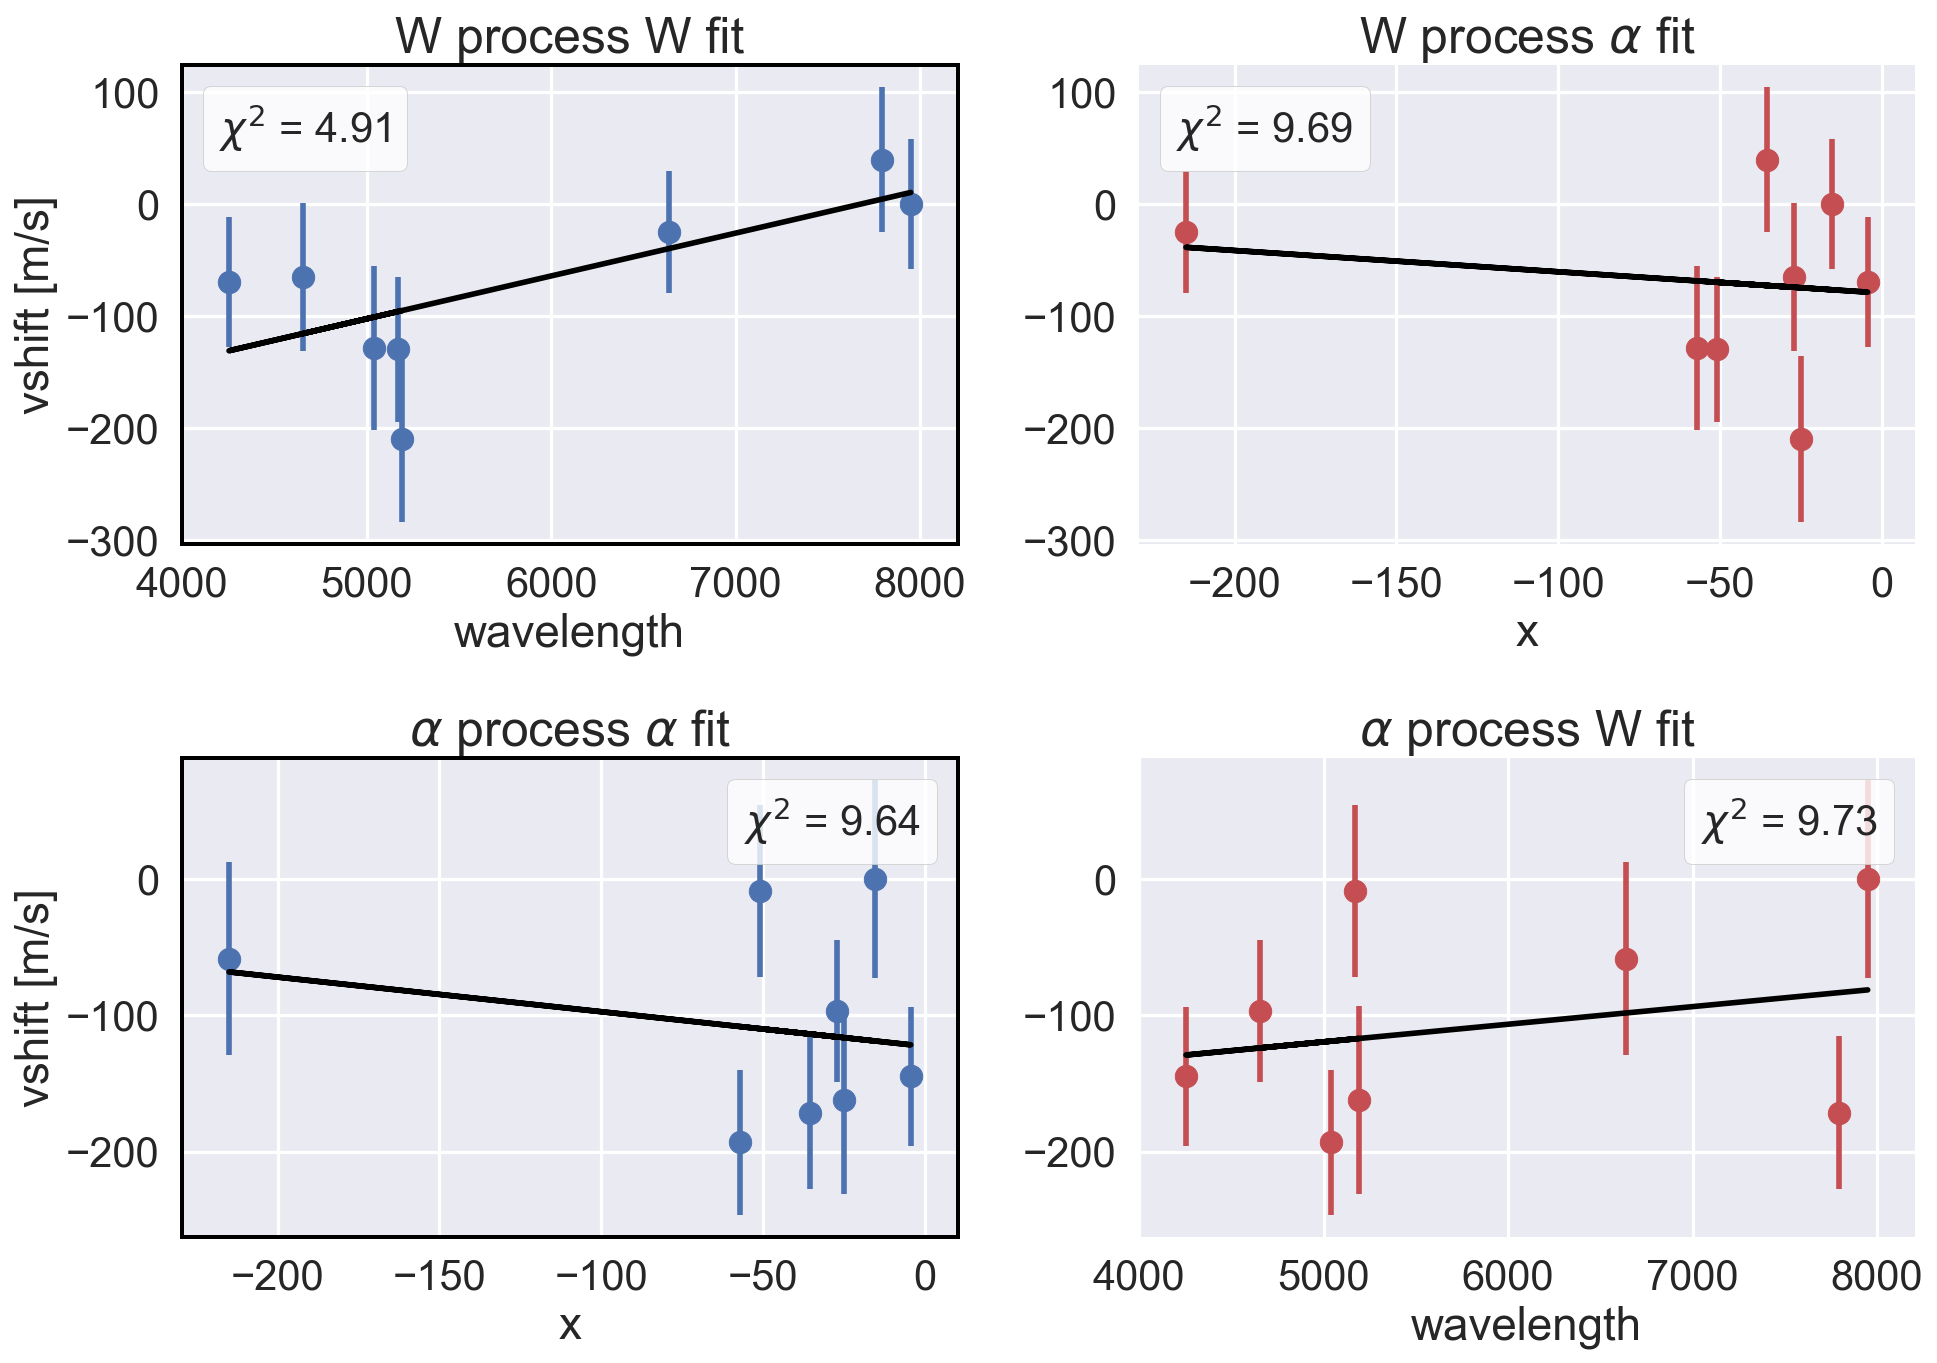

In [15]:
plot_hypotheses(231, df_a, df_w)

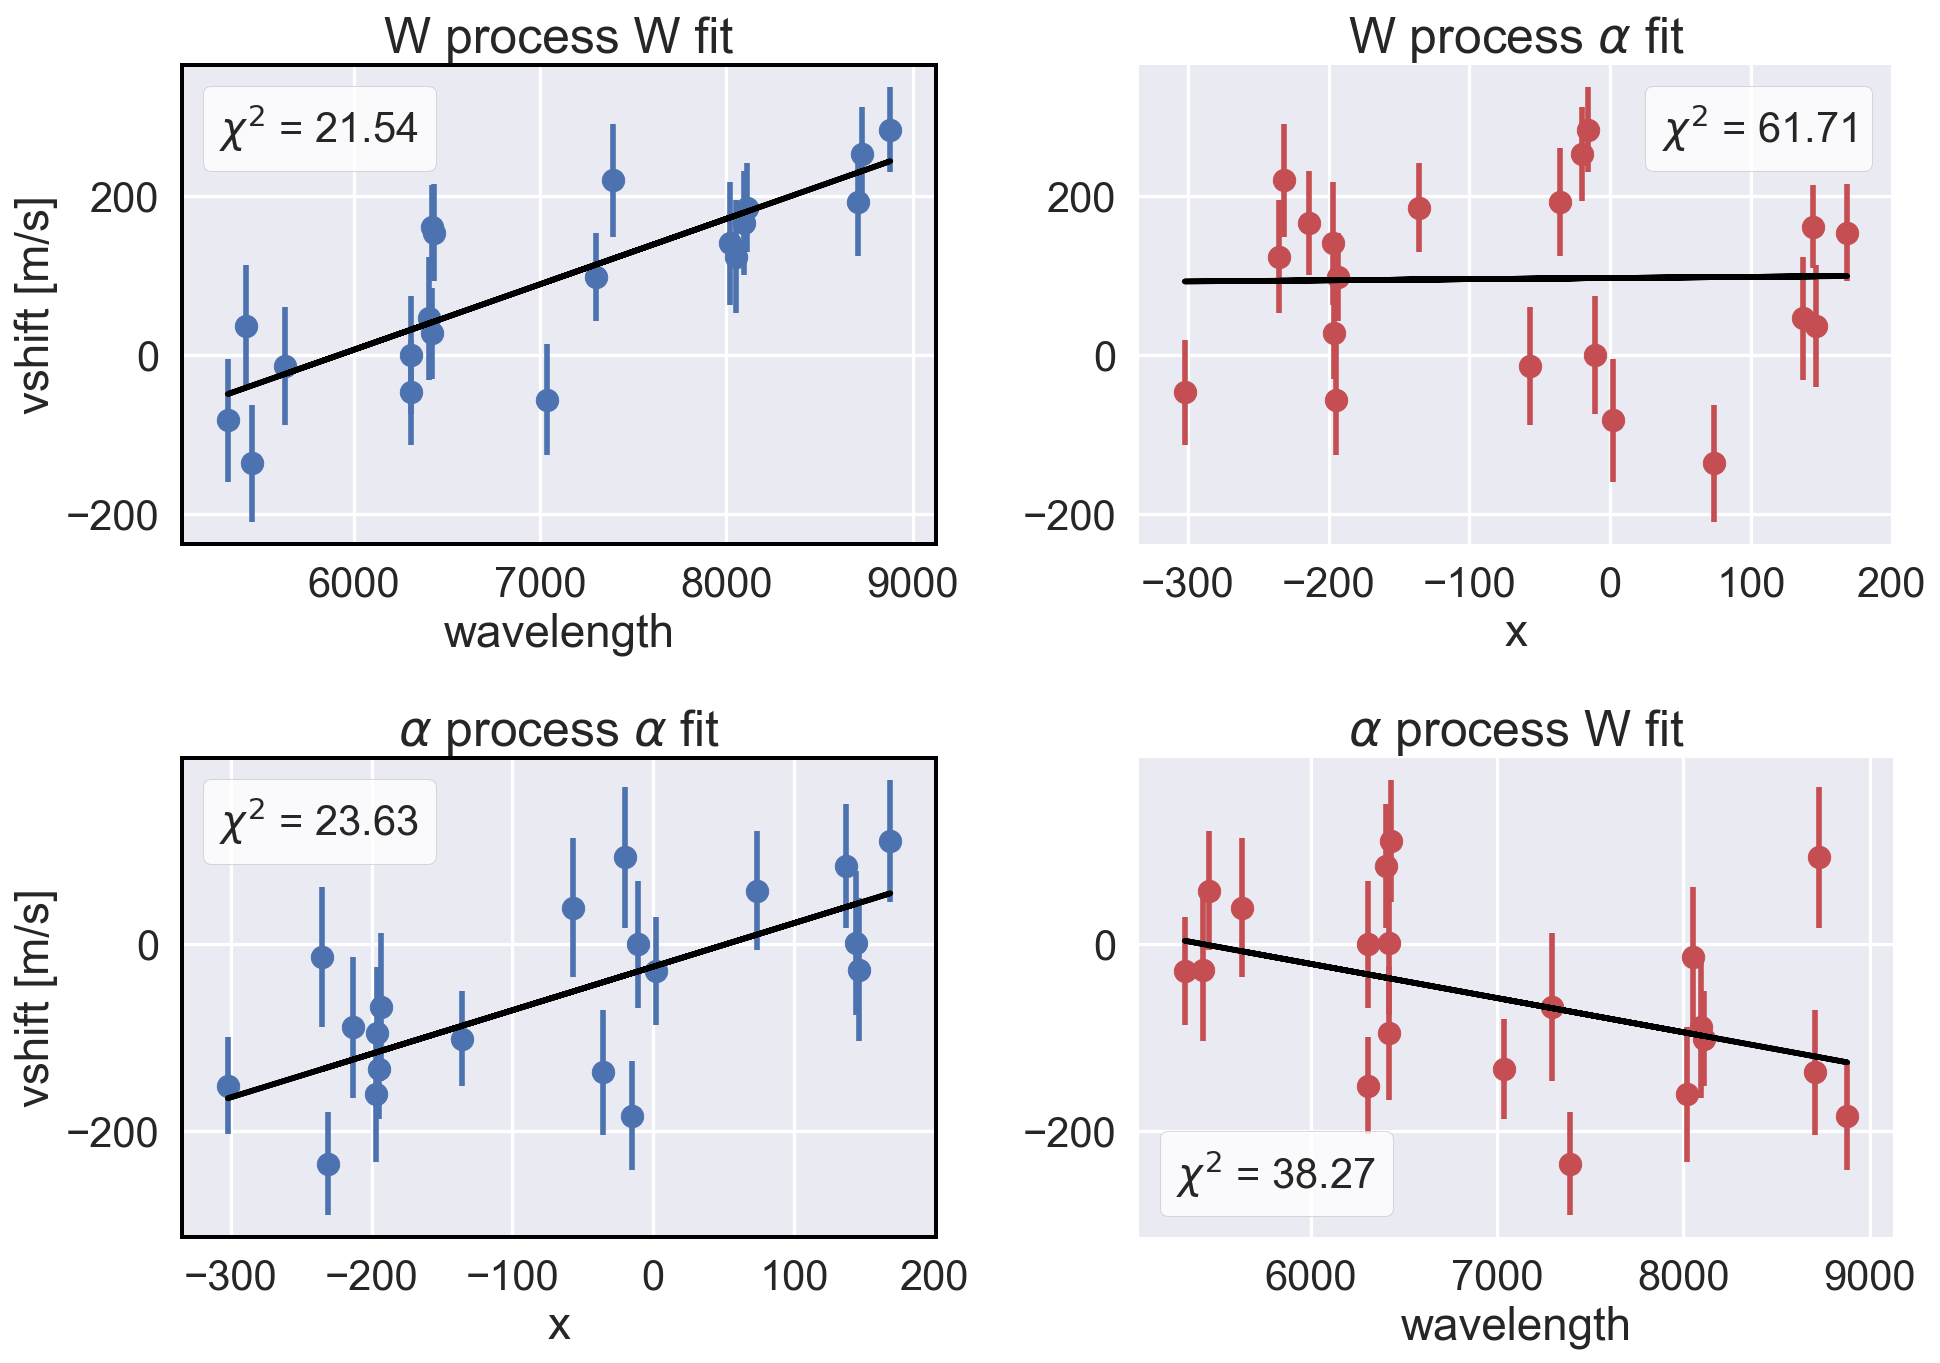

In [70]:
plot_hypotheses(264, df_a, df_w)

In [17]:
df_a[df_a.system==264][['wavelength', 'x', 'vshift', 'sigma']]

wavelength           x      vshift      sigma
1755  6307.606019  -10.570881    0.000000  67.976694
1756  8880.132002  -15.395341 -183.532169  58.355253
1757  8703.930794  -35.545013 -137.297620  66.331114
1758  8726.270535  -20.339554   92.848987  75.616709
1759  7036.901052 -194.518419 -133.810894  53.660659
1760  7296.596596 -193.263758  -67.622065  79.228620
1761  7390.744395 -231.349696 -234.822291  54.856296
1762  8051.204649 -234.963760  -13.484665  74.865876
1763  8093.295722 -213.586285  -88.895179  75.334126
1764  5627.621790  -57.021421   39.181348  74.643997
1765  6400.314994  136.852178   83.482650  66.500987
1766  6418.916085  144.421525    1.191747  77.352706
1767  6431.141238  168.482323  110.252705  65.407266
1768  6306.554306 -302.252500 -151.424592  51.622702
1769  6420.236917 -196.023305  -95.371981  71.310984
1770  5321.313473    2.050106  -28.727743  57.401675
1771  5420.757525  146.189238  -27.174443  76.853809
1772  5453.012154   73.529547   57.321850  63.162448
1773  8020.831197 -197.150297 -160.717142  71.998956
1774  8112.791439 -135.805536 -101.281514  50.916272

In [230]:
chisqs = {# data_hypo
            'x_x':[],
            'x_w':[],
            'w_x':[],
            'w_w':[]}

data = {'x':df_a, 'w':df_w}
for system in sorted(df_w.system.unique()):
    for df in ['x', 'w']:
        for hypo in ['x', 'w']:
            chisq, results = fit_hypothesis(system=system, dataframe1=data[df], hypothesis=hypo)
            chisqs['_'.join([df, hypo])].append(chisq)
for item in chisqs:
    chisqs[item] = np.array(chisqs[item])

In [245]:
np.sum(chisqs['w_x']/chisqs['w_w'] < 1.0) / len(chisqs['w_x'])

0.058020477815699661

In [253]:
np.sum(chisqs['x_x']/chisqs['x_w'] < 1.0) / len(chisqs['w_x'])

0.90443686006825941

In [247]:
full_parse.head()

#J2000   zem     zabs     da    eda sample source  sigflag  \
0  J000149-015940  2.31  2.09510   0.34   7.27     B1   Keck        2   
1  J000149-015940  2.31  2.15390  36.05  39.54     B1   Keck        1   
2  J000322-260316  4.11  1.43420 -12.53  11.67      C   Keck        1   
3  J000322-260316  4.11  3.38970 -78.43  35.48      C   Keck        1   
4  J000520+052410  1.90  0.59137 -31.05  24.33      C   Keck        1   

   imrotator               transition  
0          0  d g h i j k l s t u v w  
1          0                  d f g l  
2          1                  b c p r  
3          1                  d g l m  
4          0              b c n p q r

In [251]:
angles = []
dipole_alphas = []
measured_alphas = []

for index, row in full_parse.iterrows():
    name = row['#J2000']
    angles.append(j2000_to_theta(name))
    dipole_alphas.append(dipole_alpha(name))
    measured_alphas.append(row.da)

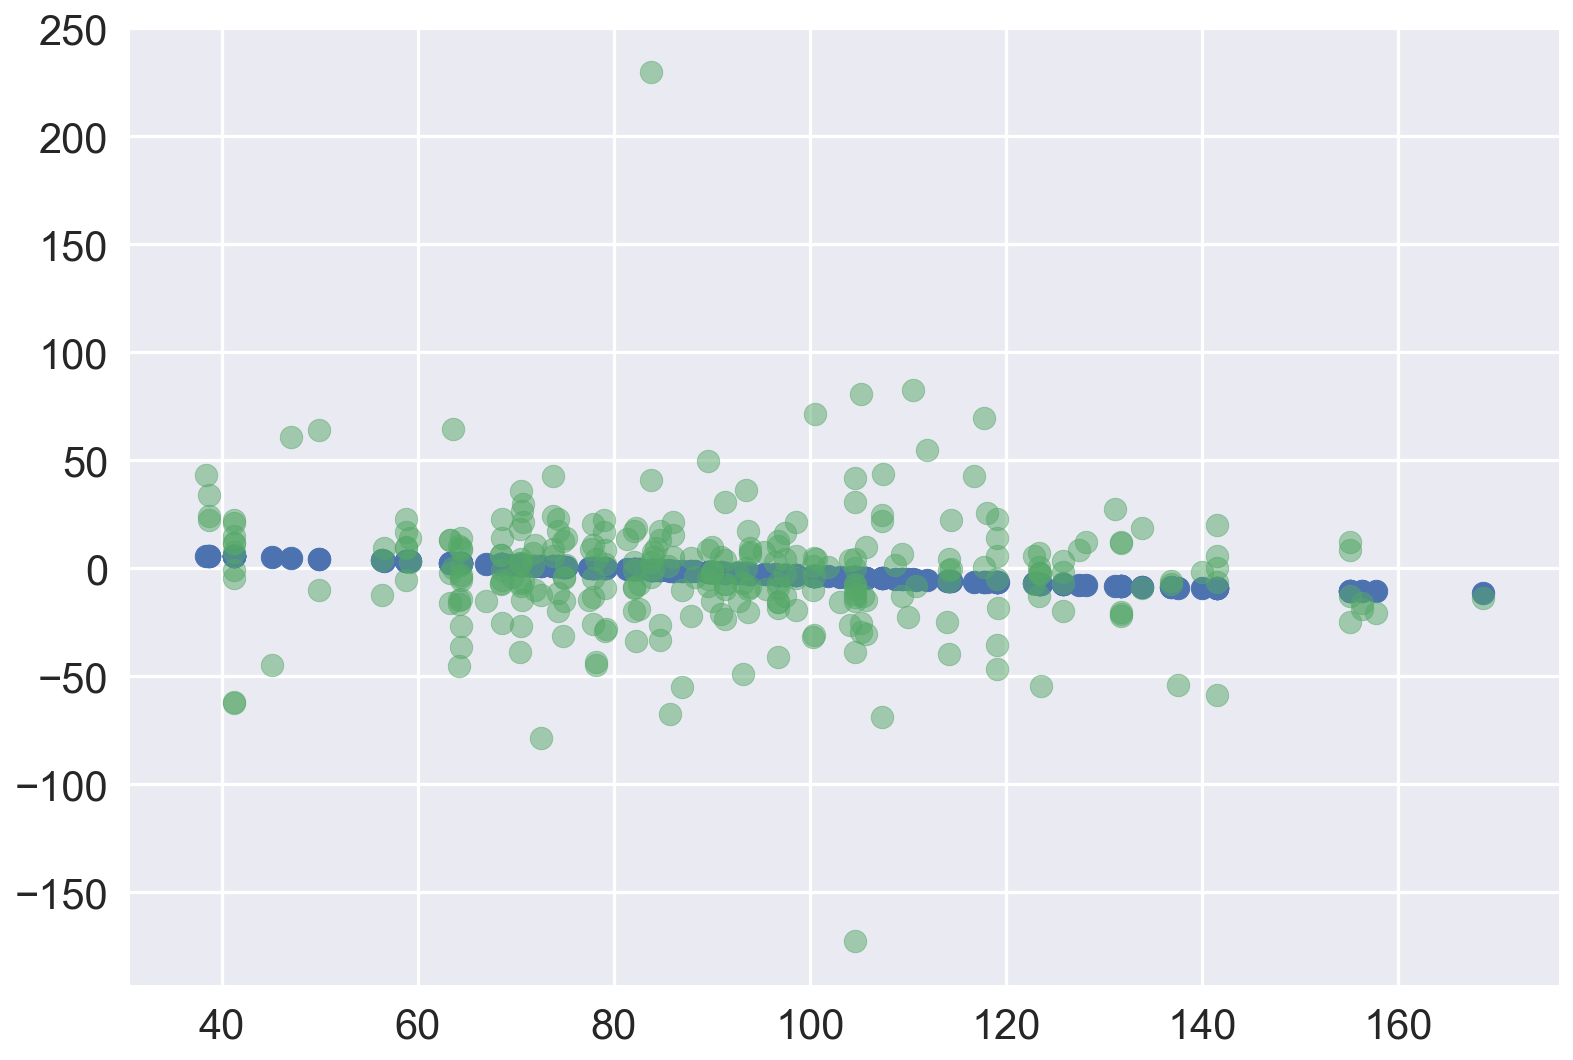

In [264]:
plt.scatter(angles, dipole_alphas)
plt.scatter(angles, measured_alphas, alpha=0.5)

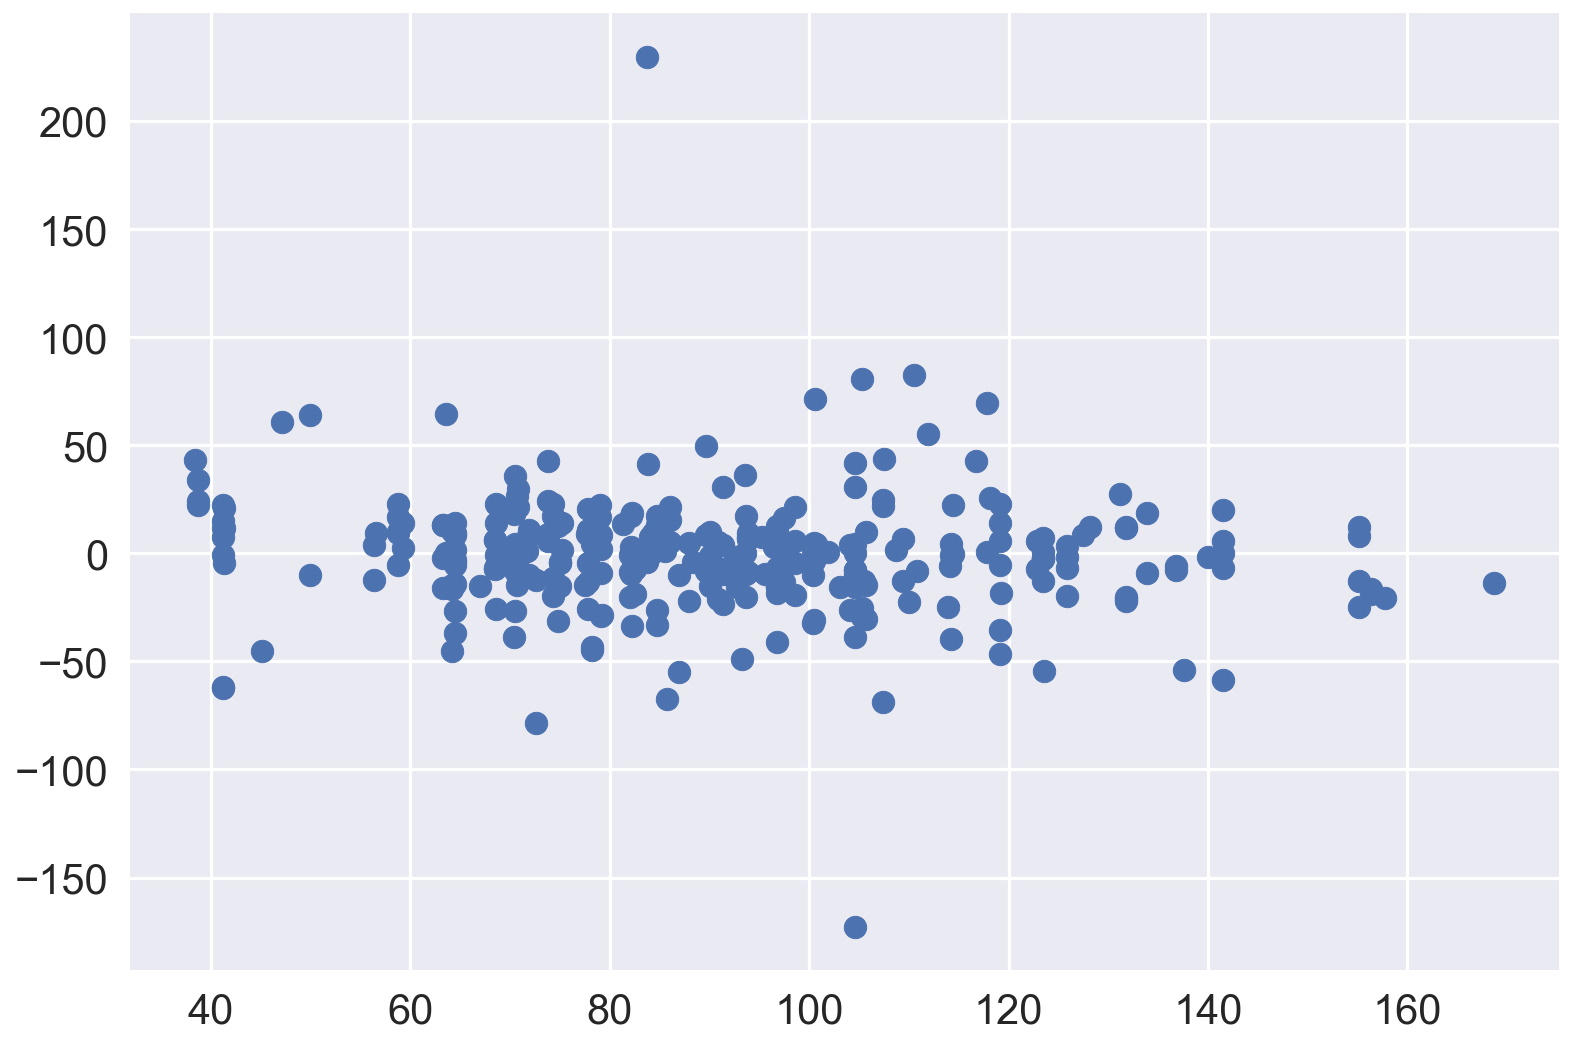

In [263]:
plt.scatter(angles, measured_alphas)

In [ ]:
# Todo: ipywidgets minimization of spline + offsets for vshift

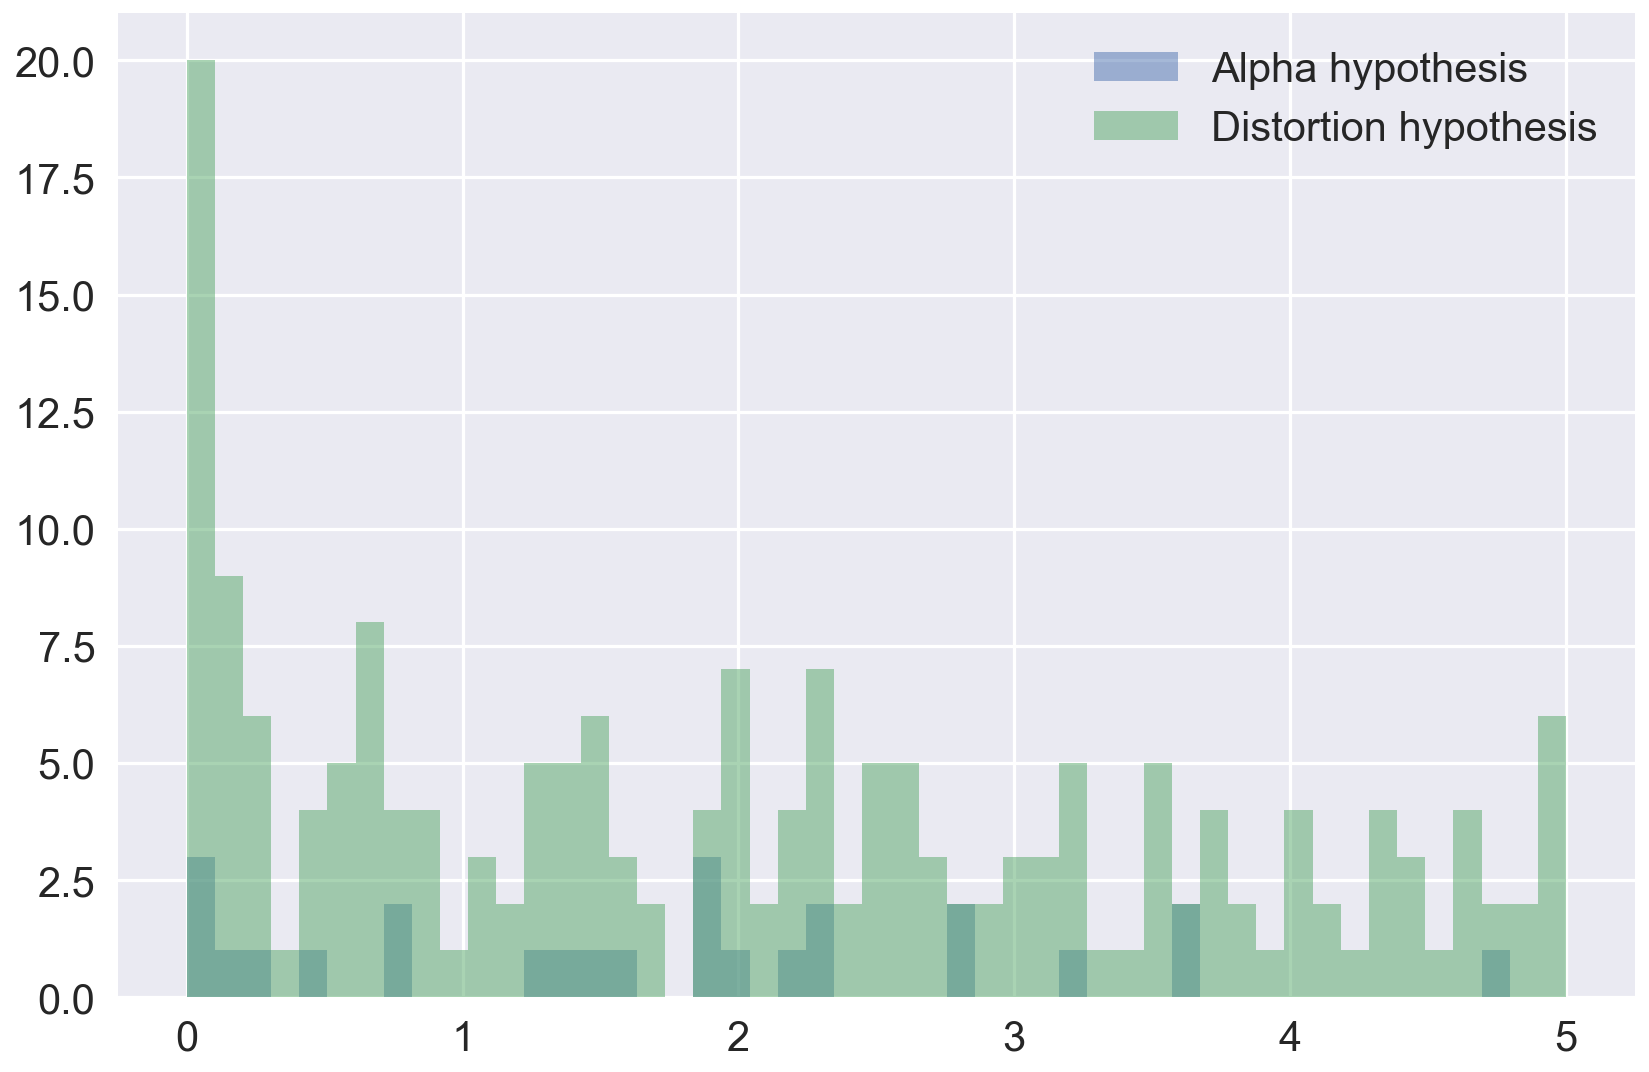

In [329]:
alpha = []
distortion = []
for (index, g) in df2.groupby('system'):
    X = sm.add_constant(g.x)
    model = sm.WLS(g.vshift, X, weights=1.0/g.sigma)
    results = model.fit()
    chisq = np.sum((g.vshift - results.fittedvalues)**2.0 / (g.sigma) ** 2.0)
    if chisq < 1e7:
        alpha.append(chisq)
    
    X = sm.add_constant(g.wavelength)
    model = sm.WLS(g.vshift, X, weights=1.0/g.sigma)
    results = model.fit()
    chisq = np.sum((g.vshift - results.fittedvalues)**2.0 / (g.sigma) ** 2.0)
    if chisq < 1e10:
        distortion.append(chisq)

alpha = np.array(alpha)
distortion = np.array(distortion)
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(alpha, alpha=0.5, 
                bins=np.linspace(0, 5, 50),
        label='Alpha hypothesis')
ax.hist(distortion, alpha=0.5, 
                        bins=np.linspace(0, 5, 50),
        label='Distortion hypothesis')
# ax.hist(alpha / distortion, 
#         bins=np.linspace(0, 5, 50), 
#         label='Wavelength',
#         alpha=0.5)
# ax.set_xlim(0, 5.0, )
ax.legend()
fig.tight_layout()

# Alpha measurements as proxies for wavelength distortions

We have many measurements of $\alpha$ on both the [Keck](https://en.wikipedia.org/wiki/W._M._Keck_Observatory) and [VLT](https://en.wikipedia.org/wiki/Very_Large_Telescope) telescopes. Measurements with spectrographs both telescopes reveal statistically significant (though small in absolute terms) differences between the expected positions of absorption lines and the measured positions. 


## Hypothesis tests or statistical inference

There are many possible hypotheses that could explain these differences. To list just two: 

 - the value of the fine-structure constant ($\alpha$) has changed
 - there are velocity distortions in the instrument.
 
We can consider any velocity shift measurements as a hypothesis test. Previous studies started with the assumption that any shift in absorption lines would come as a result of a change in $\alpha$. We have the reported $\frac{\Delta \alpha}{\alpha}$ values for both the Keck and VLT samples. If we invert the hypothesis: use the measured alpha values as a system of velocity shifts, we can effectively discriminate which hypothesis best fits the data.

## Simulations

The goal will be to simulate what the velocity shifts look like if the dipole model is correct, and compare that to what we currently see.


## Discussion

The end goal of this analysis is ultimately a change in how $\frac{\Delta \alpha}{\alpha}$ is measured. The proposed recipe is:

 1. Create the best fit velocity structure as usual.
 2. Fit for relative velocity shifts between all lines (`vpfit` already allows for this).
 3. Combine all velocity shifts for all measured systems with a particular telescope.
 4. Use standard hypothesis statistical tests to discriminate the most likely hypothesis: a wavelength distortion model, or a change in the fine-structure constant.

This will likely have rather low power for any single absorption system, but for ensembles, I think that it's likely the only case 



## Useful References (in reverse chronological order)

 - [Modeling long-range wavelength distortions in quasar absorption echelle spectra](https://arxiv.org/abs/1701.03176) (2017) by Vincent Dumont, John K. Webb
 - [Artificial intelligence applied to the automatic analysis of absorption spectra. Objective measurement of the fine structure constant](https://arxiv.org/abs/1606.07393) (2016) by Matthew B. Bainbridge, John K. Webb
 - [Impact of instrumental systematic errors on fine-structure constant measurements with quasar spectra](https://arxiv.org/abs/1409.4467) (2014) by Jonathan B. Whitmore, Michael T. Murphy
 - [Spatial variation in the fine-structure constant -- new results from VLT/UVES](https://arxiv.org/abs/1202.4758) (2012) by Julian A. King, John K. Webb, Michael T. Murphy, Victor V. Flambaum, Robert F. Carswell, Matthew B. Bainbridge, Michael R. Wilczynska, F. Elliot Koch
 - [Further evidence for a variable fine-structure constant from Keck/HIRES QSO absorption spectra](https://arxiv.org/abs/astro-ph/0306483) (2003) by Michael T. Murphy, John K. Webb, Victor V. Flambaum
 - [Does the fine structure constant vary? A detailed investigation into systematic effects](https://arxiv.org/abs/astro-ph/0210532) (2002) by M. T. Murphy, J. K. Webb, V. V. Flambaum, S. J. Curran


In [5]:
species = set([spec[0] for spec in qvals.index.str.split('I')])
colors = sns.color_palette(n_colors=len(species))
plot_colors = {}
for index, specie in enumerate(sorted(species)):
    plot_colors[specie] = colors[index]

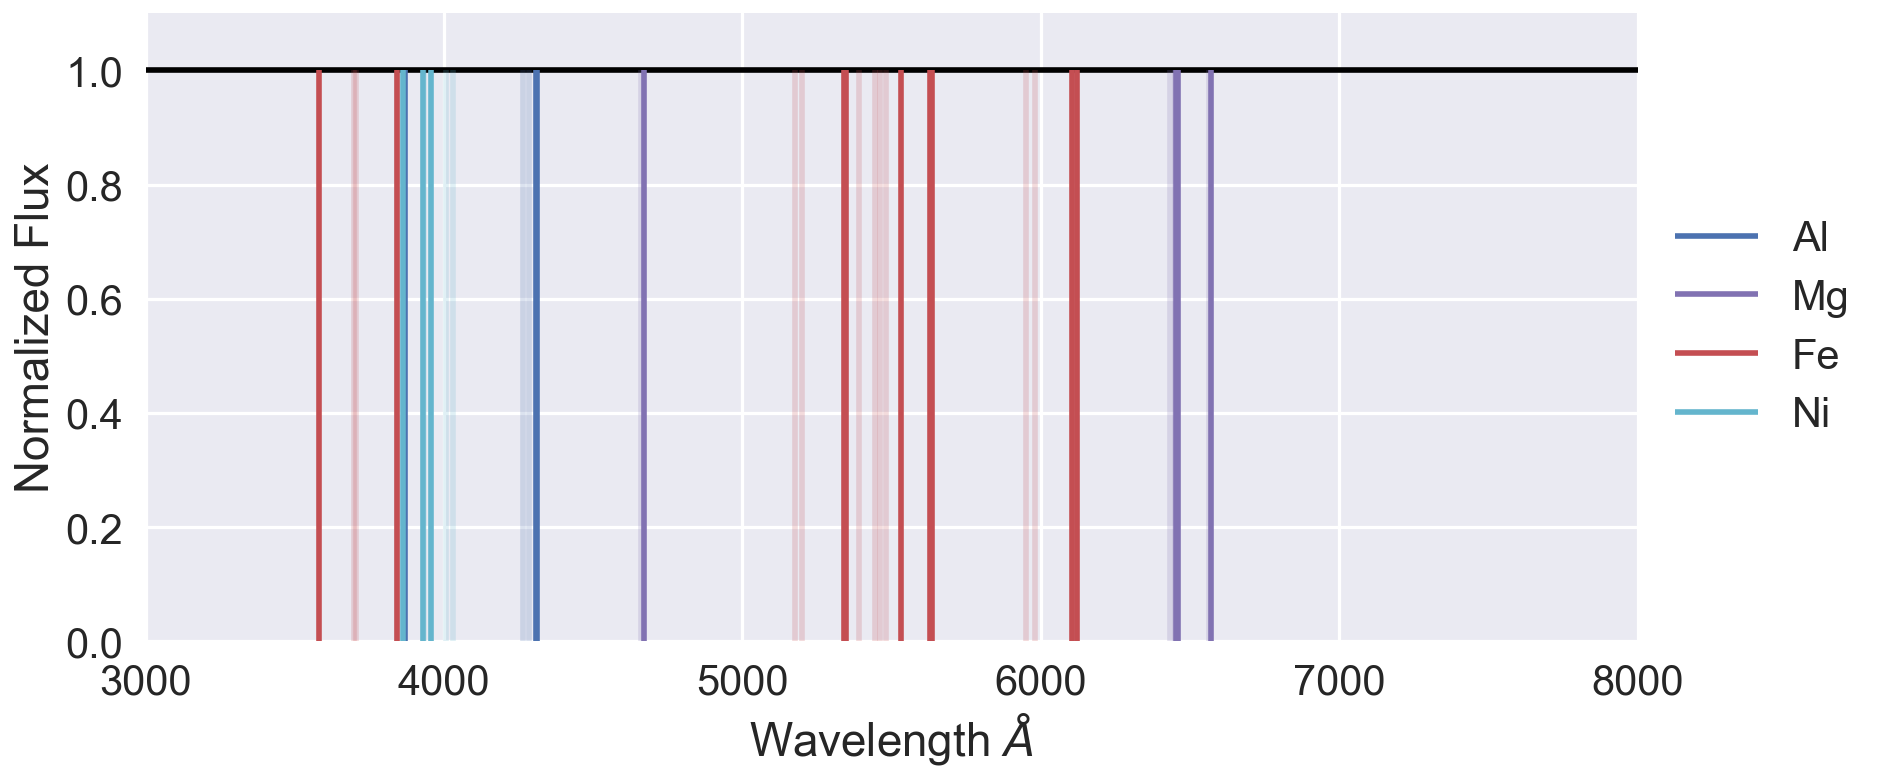

In [11]:
def plot_absorption(specie=['Al', 'Mg'],
                    z=1.3,
                    daa=0.05,
                   ):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hlines(1, 0, 10000)
    for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
        ax.vlines((1.0 + z) * row.wave + row.qval * ((daa + 1)**2.0-1.0), 
                      0, 1, color=plot_colors[tran[:2]])
        ax.vlines((1.0 + z) * row.wave, 
                      0, 1, color=plot_colors[tran[:2]], alpha=0.2)
        
    ax.set_xlim(3000, 8e3)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Normalized Flux")
    ax.set_xlabel(r"Wavelength $\AA$")
    
    for spec in specie:
        ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_absorption(specie=['Al', 'Mg', 'Fe', 'Ni'], )

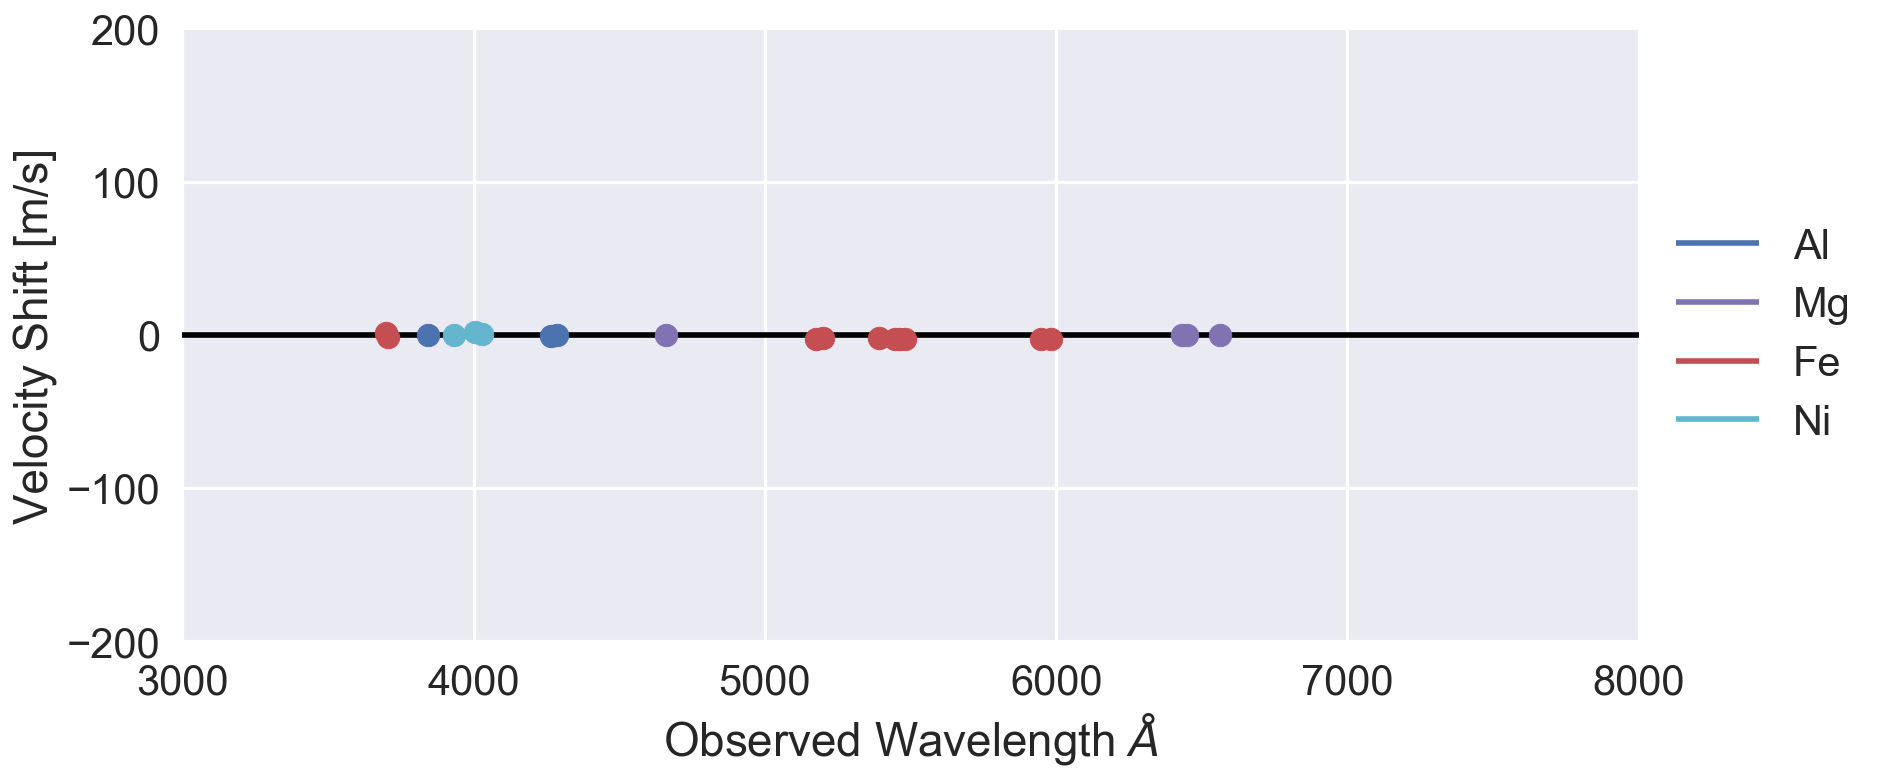

In [51]:
def plot_shift(specie=['Al', 'Mg'],
                    z=1.3,
                    daa=0.05,
                   ):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hlines(0, 0, 10000)
    for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
        ax.scatter((1.0 + z) * row.wave, 
#                    row.qval * ((daa + 1)**2.0-1.0),
                   shifted_velocity(daa, row.qval, (1.0 + z) * row.wave),
                   color=plot_colors[tran[:2]], zorder=3)
        
    ax.set_xlim(3000, 8e3)
    ax.set_ylim(-200, 200)
    ax.set_ylabel("Velocity Shift [m/s]")
    ax.set_xlabel(r"Observed Wavelength $\AA$")
    
    for spec in specie:
        ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec, zorder=-3)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_shift(specie=['Al', 'Mg', 'Fe', 'Ni'], )

In [52]:
redshift_slider = FloatSlider(value=2.1, min=0.0, max=3.5)
alpha_slider = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1)
species_select = SelectMultiple(options=['Al', 'Cr', 'Fe', 'Mg', 'Mn', 'Ni', 'Si'],
                                description="Species",
                                value=['Al', 'Fe']
                               )
# w = interactive(plot_absorption, 
#                 specie=species_select,
#                 z=redshift_slider,
#                 daa=alpha_slider,
#                )
shift_interactive = interactive(plot_shift, 
                specie=species_select,
                z=redshift_slider,
                daa=alpha_slider,
               )

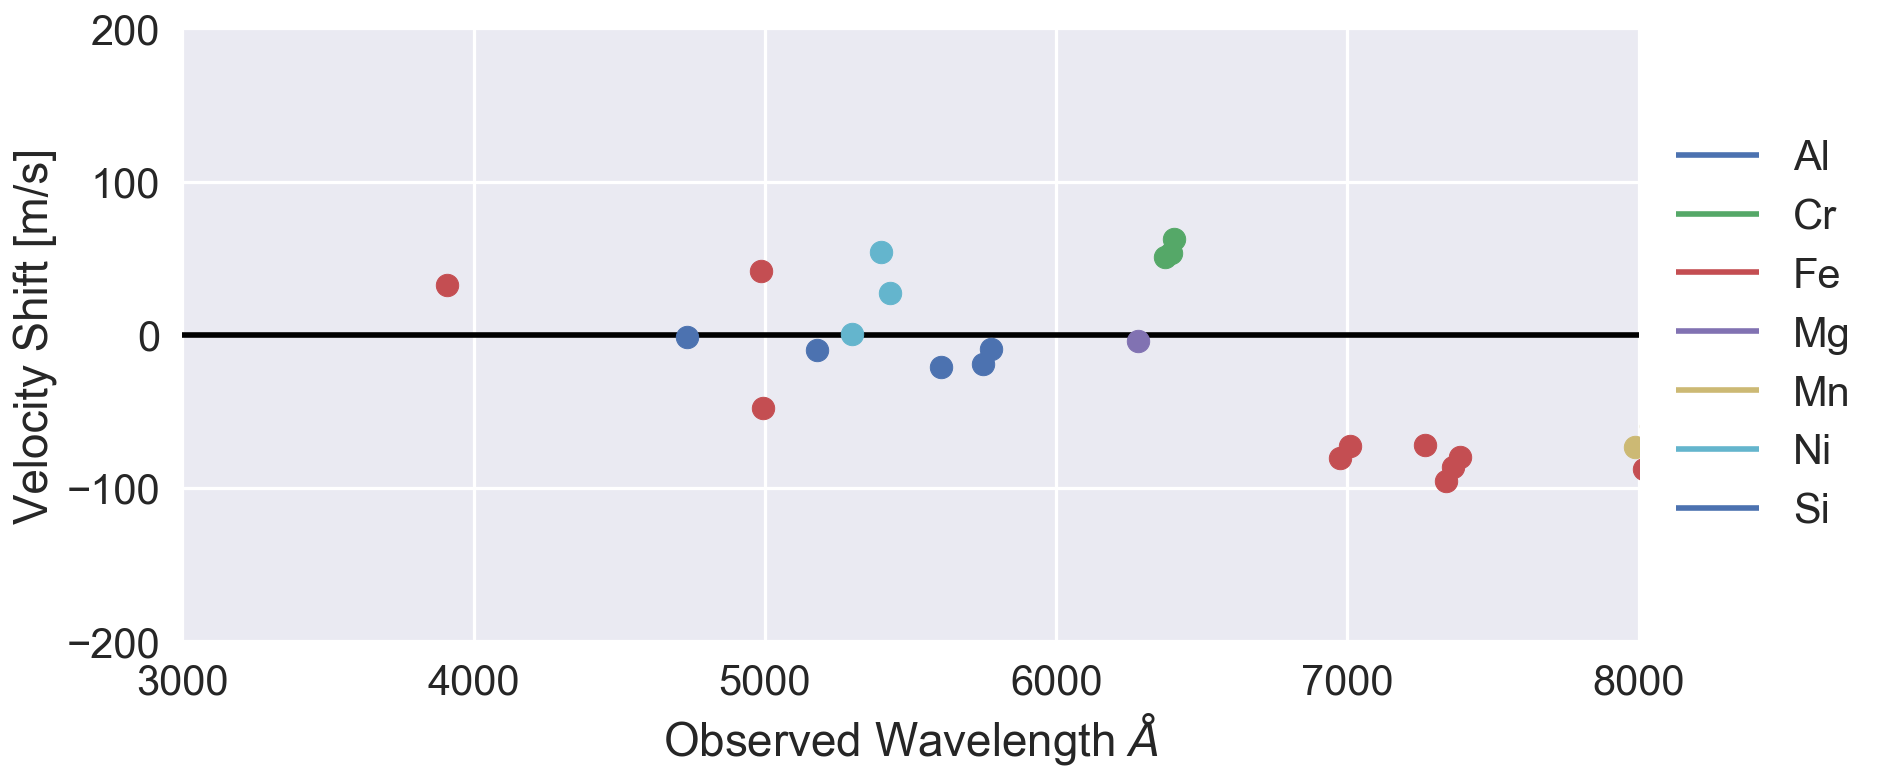

In [53]:
shift_interactive

In [42]:
full_parse.head()

#J2000   zem     zabs     da    eda sample source  sigflag  \
0  J000149-015940  2.31  2.09510   0.34   7.27     B1   Keck        2   
1  J000149-015940  2.31  2.15390  36.05  39.54     B1   Keck        1   
2  J000322-260316  4.11  1.43420 -12.53  11.67      C   Keck        1   
3  J000322-260316  4.11  3.38970 -78.43  35.48      C   Keck        1   
4  J000520+052410  1.90  0.59137 -31.05  24.33      C   Keck        1   

   imrotator               transition  
0          0  d g h i j k l s t u v w  
1          0                  d f g l  
2          1                  b c p r  
3          1                  d g l m  
4          0              b c n p q r

In [15]:
def plot_shifts(telescope='VLT'):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.2}, ax=ax)
    ax.set_ylim(-200, 200)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(telescope)
    fig.tight_layout()

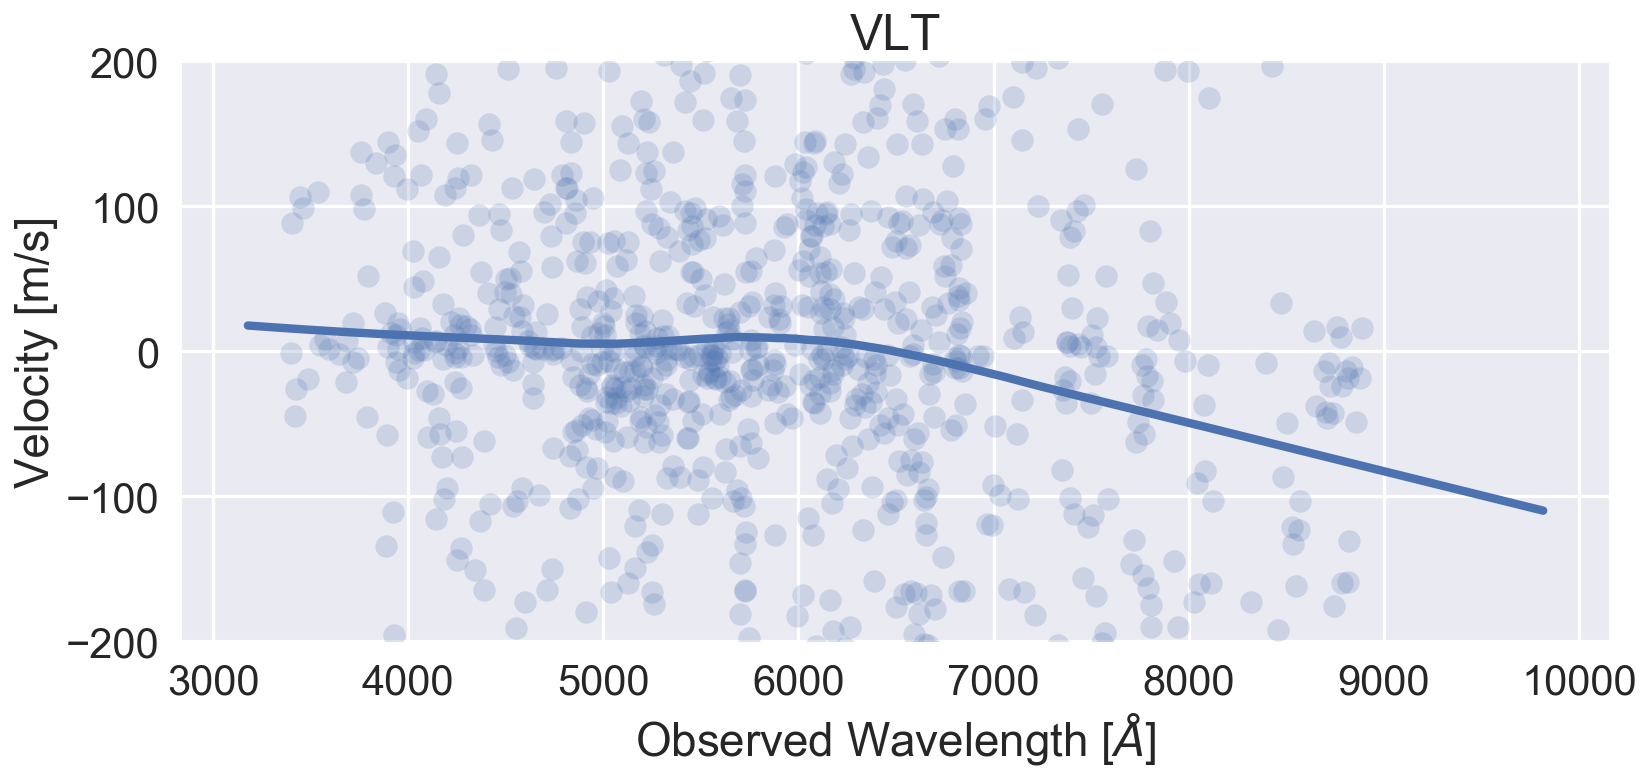

In [16]:
plot_shifts(telescope='VLT')

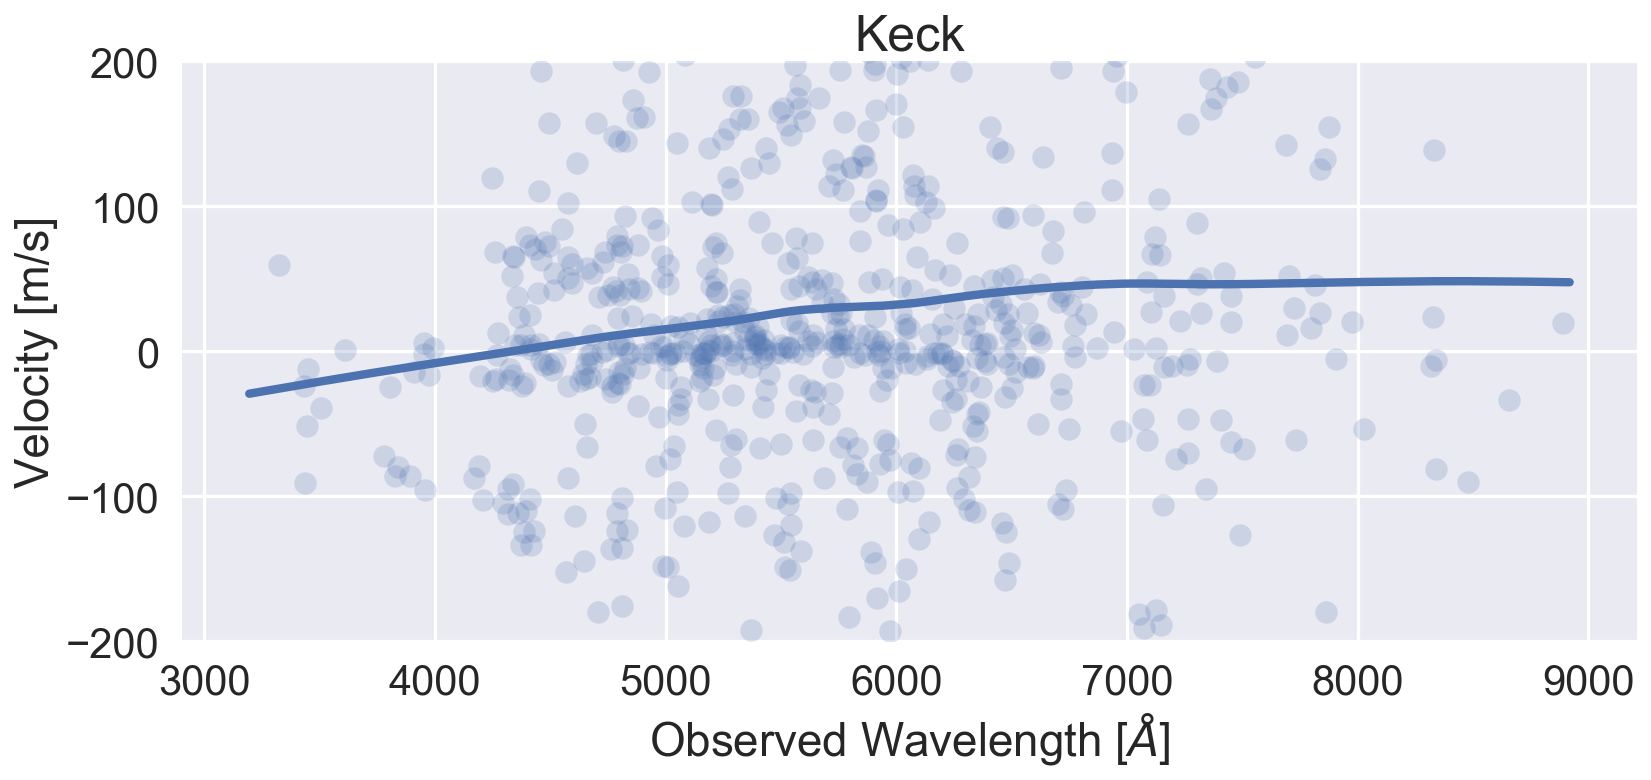

In [17]:
plot_shifts(telescope='Keck')

In [59]:
def plot_all(title='Keck + VLT'):
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    telescope='Keck'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    ax.set_xlim(2000, 10000)
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(title)
    fig.tight_layout()

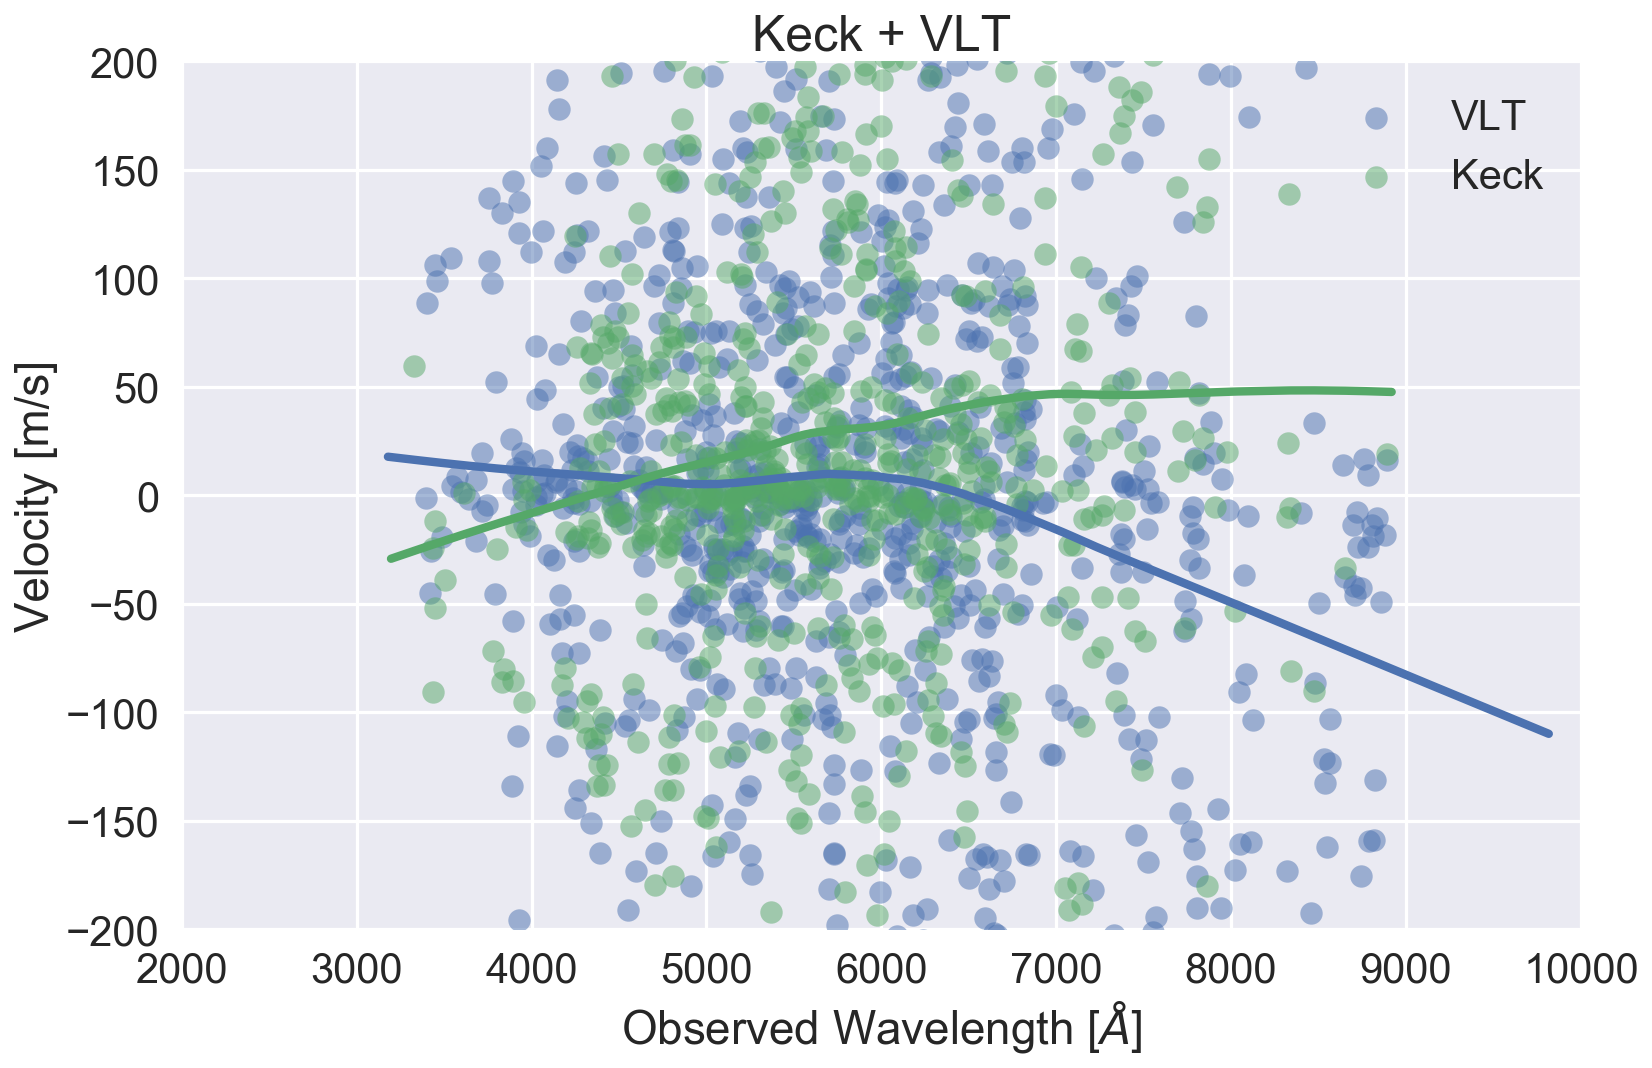

In [60]:
plot_all()

In [61]:
def observed_shifts_by_sample(sample='A'):
    waves = []
    shifts = []
    for index, row in full_parse[full_parse['sample'] == sample].iterrows():
        for tran in row['transition'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.zabs)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            shifts.append(shifted_velocity(row.da, qval, rest_wave))
    return np.array(waves), np.array(shifts)

def plot_samples():
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    for sample in sorted(full_parse['sample'].unique()):
        w, s = observed_shifts_by_sample(sample=sample)
        sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=sample)
    ax.set_ylim(-400, 400)
    ax.set_xlim(2000, 10000)
    ax.legend()
#     frame = ax.get_frame()
#     frame.set_alpha(1.0)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Samples')
    fig.tight_layout()

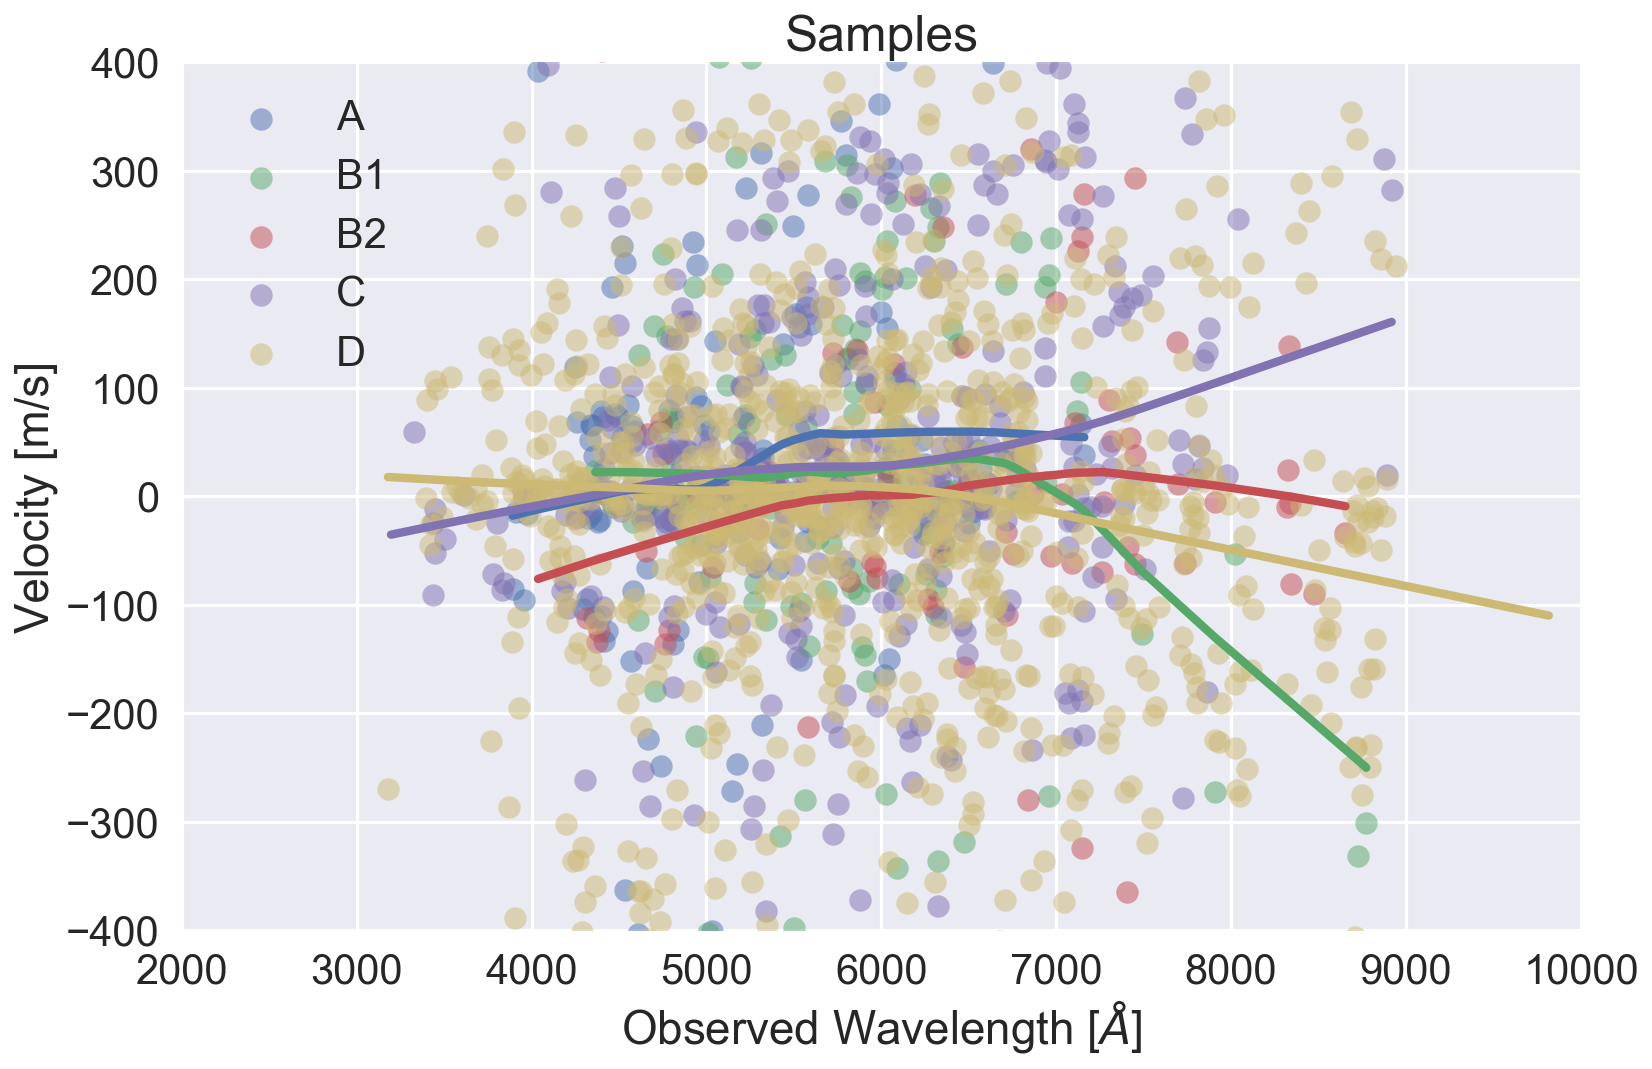

In [62]:
plot_samples()

## Simulations

Generate velocity shifts for the dipole hypothesis.

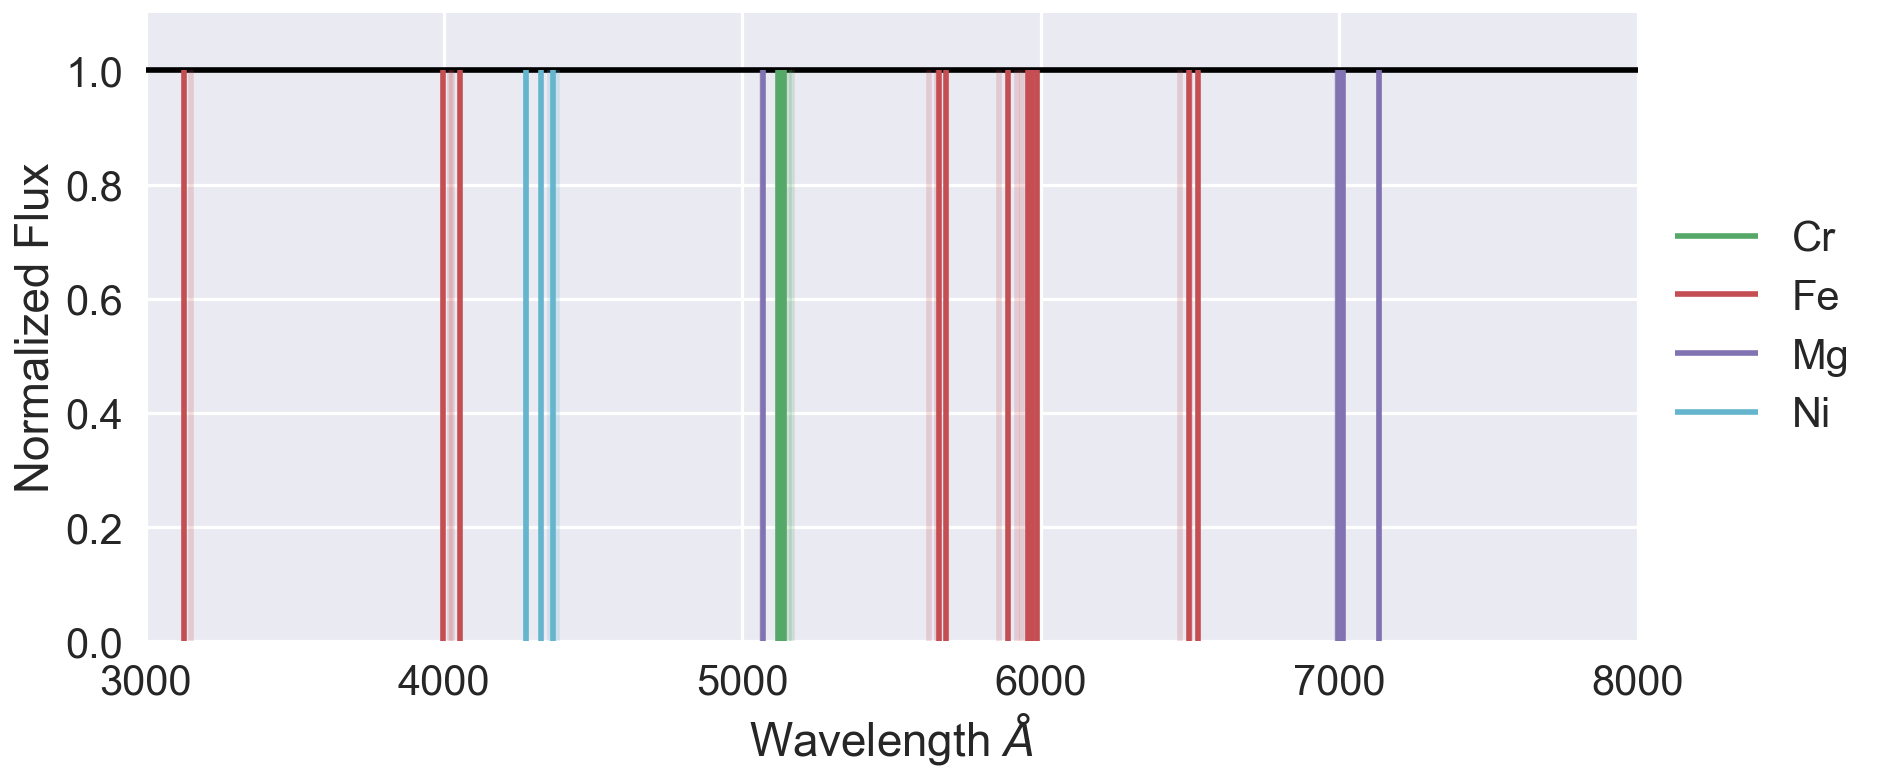

In [54]:
w

In [74]:
def plot_sim(telescope='VLT', use_dipole=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Measured VLT')
    w, s = simulated_shifts(telescope=telescope, use_dipole=use_dipole)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Dipole VLT')
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Simulated velocity shifts for ' + telescope)
    fig.tight_layout()

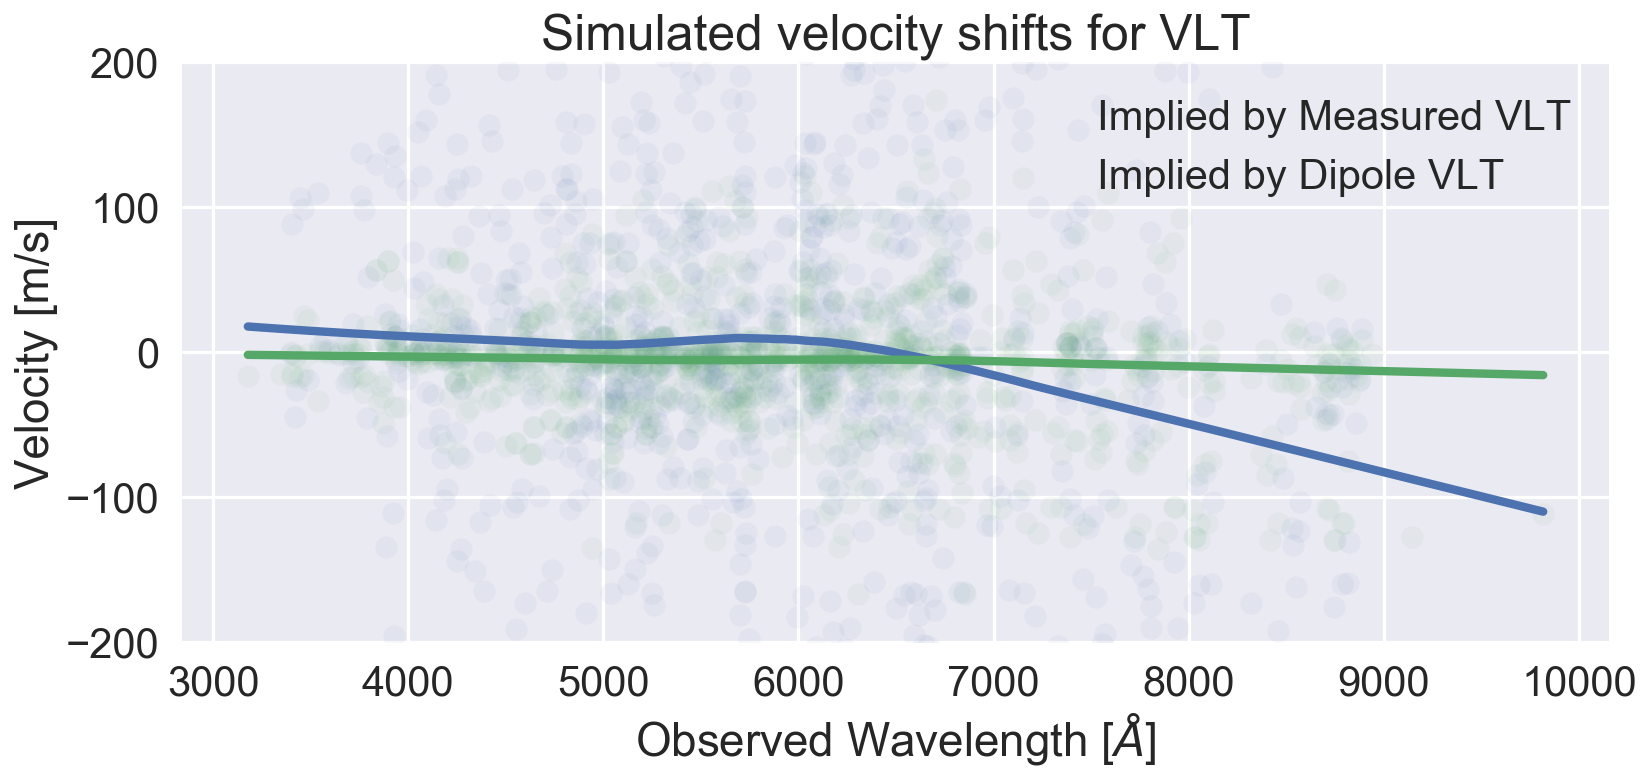

In [75]:
plot_sim()

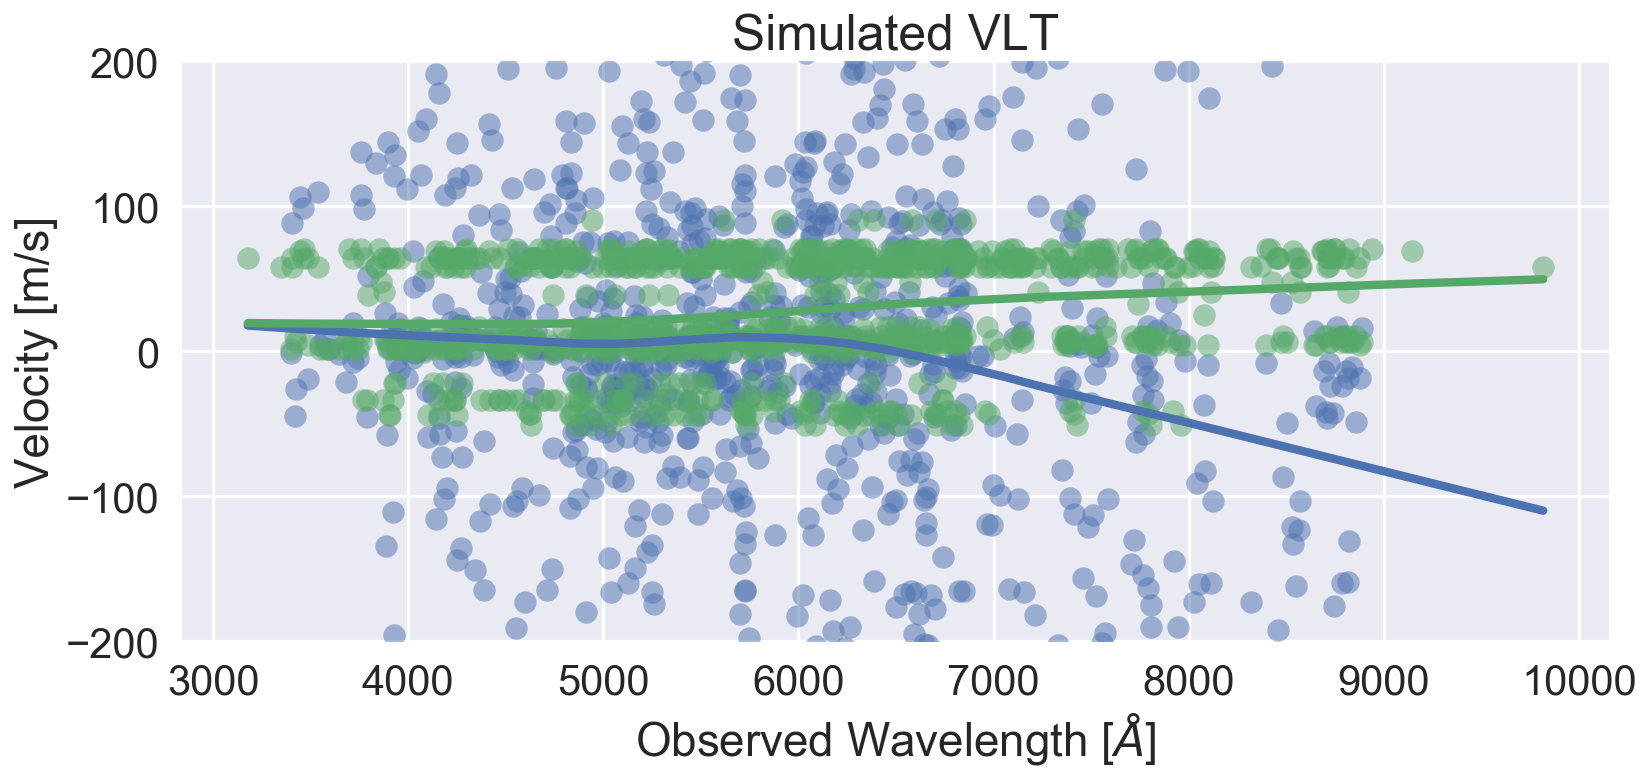

In [69]:
def simulated_shifts(telescope='VLT', use_dipole=True):
    waves = []
    shifts = []
    for index, row in full_parse[full_parse.source.eq(telescope)].iterrows():
        for tran in row['transition'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.zabs)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
#             da = row.da
            if use_dipole:
                da = dipole_alpha(row['#J2000'])
            else:
                da = -3.0
            shifts.append(shifted_velocity(da, qval, rest_wave))
    return np.array(waves), np.array(shifts)

plot_sim(use_dipole=False)

## Hypothesis test

I think that a non-parametric test for $\alpha$ would be to fit for all velocity shifts as independent shifts. 

The general procedure would be thus:

 - fit velocity shifts per wavelength region (with errors). 

#J2000   zem    zabs    da   eda sample source  sigflag  \
152  J004131-493611  3.24  2.2485 -12.3  6.72      D    VLT        3   

     imrotator                                         transition  
152          0  j1 j2 j3 j6 j7 j8 c1 d1 d2 e2 h1 h2 h3 l1 l2 k...

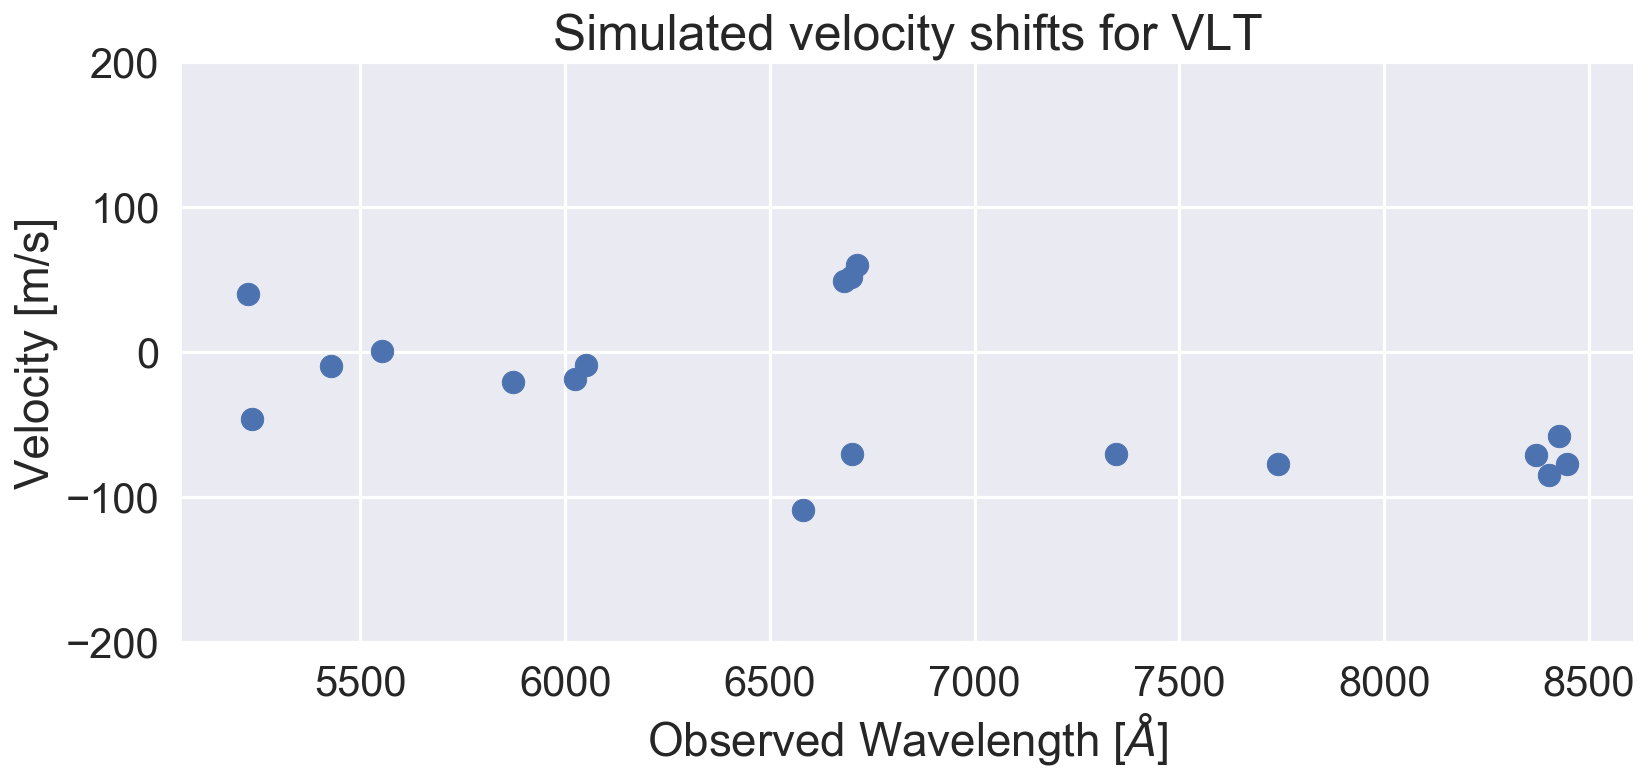

In [99]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = dipole_alpha(row['#J2000'])
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope)
fig.tight_layout()

In [ ]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = dipole_alpha(row['#J2000'])
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(np.round(da, 2)))
fig.tight_layout()

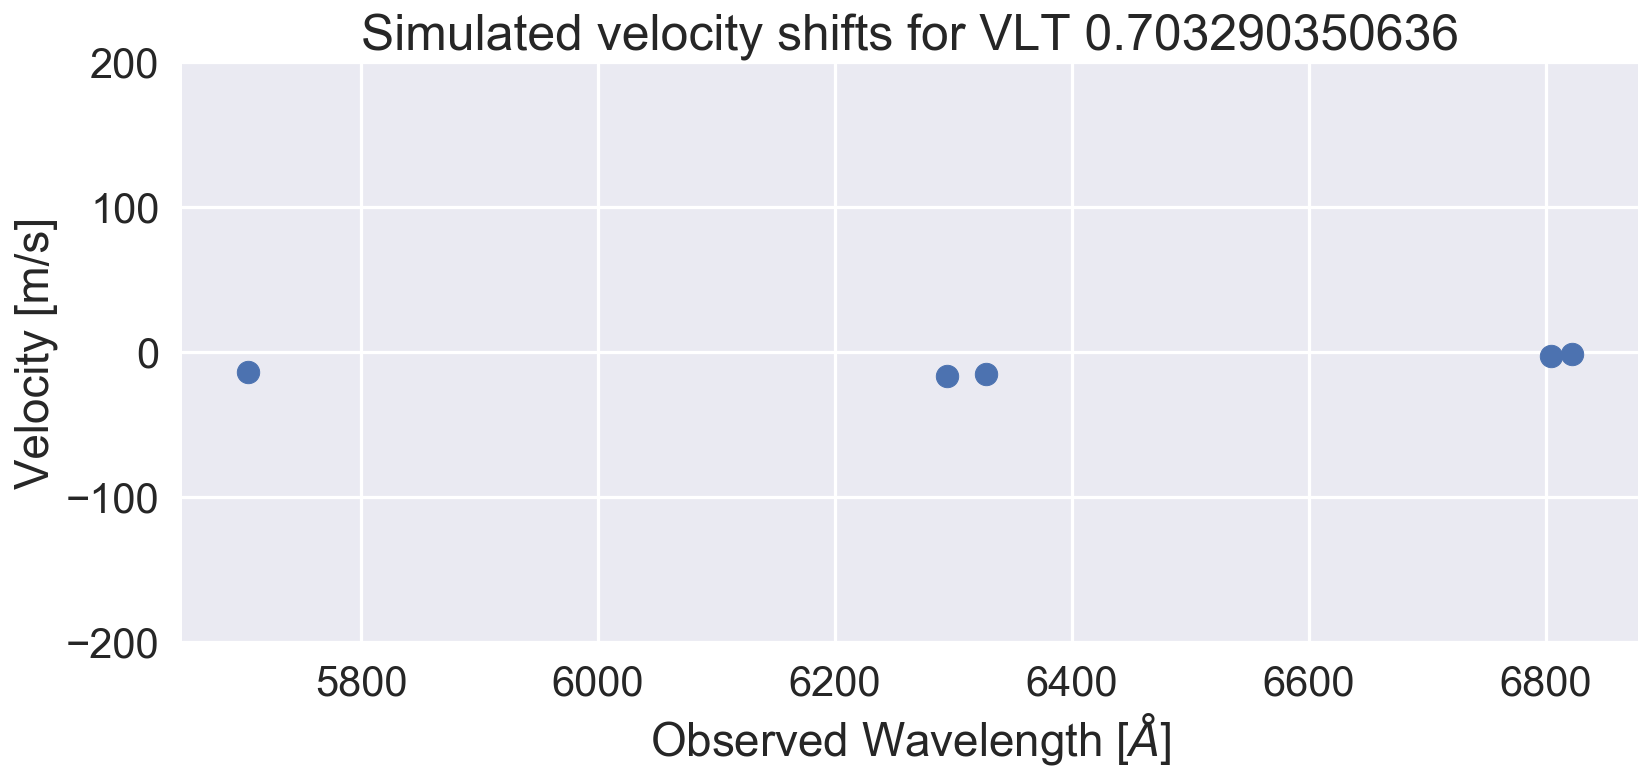

In [113]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=3
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = dipole_alpha(row['#J2000'])
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()

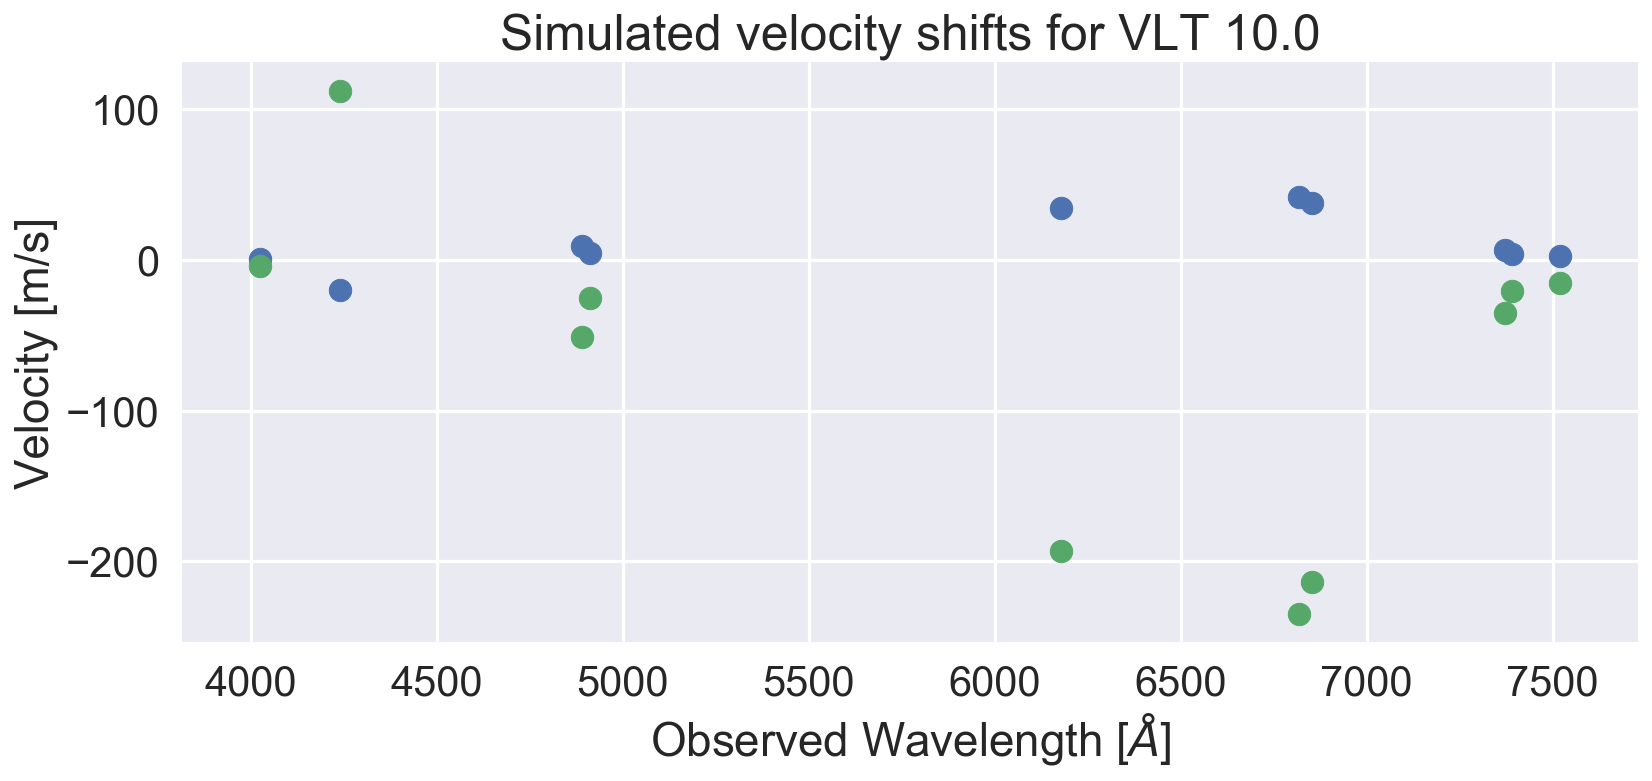

In [112]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=8
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
    da = dipole_alpha(row['#J2000'])
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)

waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
    da = row.da
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)

ax.scatter(wav, shift)
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()